In [1]:
from __future__ import division

# Standard library imports
import math as mt
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import boxcox

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Machine learning and data preprocessing
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, RobustScaler, 
                                   QuantileTransformer, PowerTransformer, MaxAbsScaler)

# Specialized visualization
import ptitprince as pt

# Configuration and settings
warnings.filterwarnings('ignore')  # Ignore warnings
pd.options.display.float_format = "{:,.2f}".format  # Set float format for pandas

# FUNCTIONS

In [2]:
def transform_column(dataframe, input_column_name):
    df = dataframe.copy()

    # 1. Quantile Transformation (Uniform)
    quantile_uniform_scaler = QuantileTransformer(output_distribution='uniform')
    df[f'quantile_uniform_{input_column_name}'] = quantile_uniform_scaler.fit_transform(df[input_column_name].values.reshape(-1, 1))

    # 2. Standard Scaling
    standard_scaler = StandardScaler()
    df[f'standard_scaled_{input_column_name}'] = standard_scaler.fit_transform(df[input_column_name].values.reshape(-1, 1))

    # 3. Min-Max Scaling
    minmax_scaler = MinMaxScaler()
    df[f'minmax_scaled_{input_column_name}'] = minmax_scaler.fit_transform(df[input_column_name].values.reshape(-1, 1))

    # 4. Robust Scaling
    robust_scaler = RobustScaler()
    df[f'robust_scaled_{input_column_name}'] = robust_scaler.fit_transform(df[input_column_name].values.reshape(-1, 1))

    # 5. Log Transformation (adding a small constant to handle possible zeros)
    df[f'log_transformed_{input_column_name}'] = np.log(df[input_column_name] + 1)

    # 6. Square Root Transformation
    df[f'sqrt_transformed_{input_column_name}'] = np.sqrt(df[input_column_name])

    # 7. Box-Cox Transformation
    df[f'boxcox_transformed_{input_column_name}'], _ = boxcox(df[input_column_name] + 1)
    
    # 8. Yeo-Johnson Transformation (from PowerTransformer)
    yeo_johnson_transformer = PowerTransformer(method='yeo-johnson')
    df[f'yeo_johnson_{input_column_name}'] = yeo_johnson_transformer.fit_transform(df[input_column_name].values.reshape(-1, 1))

    # 9. Max Absolute Scaling
    max_abs_scaler = MaxAbsScaler()
    df[f'max_abs_scaled_{input_column_name}'] = max_abs_scaler.fit_transform(df[input_column_name].values.reshape(-1, 1))

    # 10. Arcsine Square Root Transformation (assuming the data is between 0 and 1)
    df[f'arcsine_transformed_{input_column_name}'] = np.arcsin(np.sqrt(df[input_column_name]))

    # 11. Hyperbolic Tangent Transformation
    df[f'tanh_transformed_{input_column_name}'] = np.tanh(df[input_column_name])

    # 12. Z-score with Median Absolute Deviation (MAD)
    mad = df[input_column_name].mad()
    median = df[input_column_name].median()
    df[f'mad_zscore_transformed_{input_column_name}'] = (df[input_column_name] - median) / mad

    return df

def normalizing(v, n_min = 0, n_max = 1):
    result = []
    o_min, o_max = min(v), max(v)

    for v in v:
        new_v = (n_max - n_min) / (o_max - o_min) * (v - o_min) + n_min
        result.append(new_v)

    return result

def normalizing_inv(v, n_min = 1, n_max = 0):
    result = []
    o_min, o_max = min(v), max(v)

    for v in v:
        new_v = (n_max - n_min) / (o_max - o_min) * (v - o_min) + n_min
        result.append(new_v)

    return result

def sales_perct (df,df2,col1,col2):
    
    return(format(df[col1].sum(axis=0)/df2[col2].sum(axis=0), '.2f'))

def f(x):
    # Dictionary mapping order month to corresponding production capacity column
    month_to_prod_cap = {
        "jan_order": "jan_prodcap",
        "feb_order": "feb_prodcap",
        "march_order": "march_prodcap",
        "april_order": "april_prodcap",
        "may_order": "may_prodcap",
        "june_order": "june_prodcap",
        "july_order": "july_prodcap",
        "august_order": "august_prodcap",
        "sept_order": "september_prodcap",
        "october_order": "october_prodcap",
        "nov_order": "november_prodcap",
        "dec_order": "december_prodcap"
    }
    
    # Get the production capacity based on the maximum order month
    # Return 'cantfind' if the month is not in the dictionary
    return x.get(month_to_prod_cap.get(x['Max_Order_Month'], "cantfind"), "cantfind")

In [3]:
def create_uniform_cluster_boxplots(df, assigned_clusters, features):
    """
    Parameters:
    df (DataFrame): The DataFrame containing the data.
    assigned_clusters (array-like): An array of cluster assignments for each row in df.
    features (list of str): A list of column names to be used for plotting the boxplots.
    """
    # Add cluster assignments to the DataFrame if not already present
    if 'Cluster' not in df.columns:
        df['Cluster'] = assigned_clusters
        
    df= df.sort_values(by='Cluster',ascending=False)
    
    # Define the number of unique clusters
    num_clusters = df['Cluster'].unique()
    
    # Create a figure with subplots
    nrows = int(np.ceil(np.sqrt(3)))
    ncols = nrows if 3 > nrows * (nrows - 1) else nrows - 1
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(11, 8))  # Adjust figsize as needed
    
    plt.suptitle('Distribution of Dimensions across Clusters', fontsize=14, ha='left', x=0.02, y=1.31)
    title = 'Distribution_of_Dimensions_across_Clusters'


    # Flatten the axes array for easy iteration
    axes_flat = axes.flatten()

    # Plot box plots for each cluster
    for i, j in enumerate(num_clusters):
        cluster_data = df[df['Cluster'] == j]  # Filter data for the i-th cluster
        boxplot_data = [cluster_data[feature].values for feature in features]  # Collect data for all features

        # Create the boxplot with specified aesthetics
        bp = axes_flat[i].boxplot(boxplot_data,
                                  vert=True,  # Vertical box plots
                                  patch_artist=True,  # Fill with color
                                  labels=features,  # Use feature names as labels
                                  widths=0.4,  # Width of the boxplot
                                  boxprops=dict(facecolor="white", edgecolor="black"),
                                  whiskerprops=dict(color="black"),
                                  medianprops=dict(color="black"),
                                  capprops=dict(color="black"))

        # Set titles for subplots
        axes_flat[i].set_title(f'{j}')
        
        # Explicitly set the y-axis to start at 0
        axes_flat[i].set_ylim(bottom=min(0, axes_flat[i].get_ylim()[0]))

    # Hide any unused subplots
    for j in range(3, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout(rect=[0, 0.03, 1, 1.35])
    plt.subplots_adjust(wspace=0.1, hspace=0.3)  # Adjust the spacing to make sure everything fits
    plt.show()


In [4]:
def exp_plot_3(df, column, boxplottitle, plottitle):
    data = df[column]

    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 4]}, sharex=False)
    
    palette = {"A": "#104E8B", "B": "#DC868D", "C": "#B0B0B0"}
    
    categories = ['C', 'B', 'A']  # Order categories as desired

# Plot boxplots on top
    boxplot_data = [df[df['Category_Weighted_Sum_MinMax'] == category][column] for category in categories]
    boxplot_colors = [palette[category] for category in categories]  # Use this to set colors

    ax1.boxplot(boxplot_data,
            vert=False,
            patch_artist=True,
            positions=[3, 2, 1],  # Assign positions in descending order
            labels=categories,
            widths=0.6,
            boxprops=dict(facecolor="white", edgecolor="black"),
            whiskerprops=dict(color="black"),
            medianprops=dict(color="black"),
            capprops=dict(color="black"))

# Set the facecolor of the boxes to the category color
    for patch, color in zip(ax1.artists, boxplot_colors):
        patch.set_facecolor(color)
        ax1.get_yaxis().set_visible(False)
    
    # Histogram using sns.histplot
    if 'Category_Weighted_Sum_MinMax' in df.columns:
        sns.histplot(df, x=column, bins=50, edgecolor='gray', ax=ax2, kde=True, hue='Category_Weighted_Sum_MinMax', palette=palette)
        
        # Manually create the legend
        legend_labels = ['C', 'B', 'A']
        legend_colors = [palette[label] for label in legend_labels]
        

# Manually create the legend with big square patches
        legend_labels = ['C', 'B', 'A']
        legend_colors = [palette[label] for label in legend_labels]
        patches = [Rectangle((0,0), 1, 1, facecolor=color, edgecolor='none') for color in legend_colors]

        ax1.legend(patches, legend_labels, loc='upper center', bbox_to_anchor=(0.55, 1.80), ncol=6, fancybox=False, framealpha=0, columnspacing=10, fontsize='medium')
        #ax2.legend(patches, legend_labels, loc='upper center', bbox_to_anchor=(0.42, 2.05), ncol=6, fancybox=False, framealpha=0, columnspacing=7, fontsize='medium')
        ax2.legend_.remove()

    else:
        sns.histplot(data, bins=50, edgecolor='gray', ax=ax2, kde=True)

    ax2.lines[0].set_color('#0047AB')
    ax2.set_ylabel('Frequency', size=12)
    ax2.set_xlabel(plottitle, size=12)
    ax1.set_title('Prebuild Priority Score with Min-Max Normalization',loc='left',y=1.75)
    
    ax1.tick_params(axis='both', length=0)
    ax2.tick_params(axis='both', length=0)
    
    for spine in ["top", "right", "left"]:
        ax1.spines[spine].set_visible(False)
    for spine in ["top", "right"]:
        ax2.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()


In [5]:
def raincloud(df,data,title,ylabel):
    sns.set()
    sns.set_style("white")
    sns.set_style("ticks")
    # Using the actual Series you mentioned
    series_data = df[data]

    # Create the raincloud plot
    fig, ax = plt.subplots(figsize=(9, 5))
    sns.reset_orig()
    pt.RainCloud(y=series_data,
                 orient='h',
                 width_viol=.8, 
                 width_box=.8,
                 palette=["gray"],  # Setting color to 
                 ax=ax)
    plt.title(title,size=14,loc='left',y=1.05)
    #plt.ylabel(ylabel,size=12,rotation=90)
    sns.despine()
    ax.set(xlabel=None)
    # Remove y-axis ticks
    ax.yaxis.set_ticks([])
    ax.tick_params(axis='both', length=0)
    ax.spines['left'].set_visible(False)
    plt.show()
    #fig.savefig("filename.png", dpi=300)

In [6]:
def create_cluster_boxplots(fuzzy_clusters, assigned_clusters):
    if 'Cluster' not in fuzzy_clusters.columns:
        fuzzy_clusters['Cluster'] = assigned_clusters
    
    fuzzy_clusters= fuzzy_clusters.sort_values(by='Cluster',ascending=False)
    
    num_clusters = fuzzy_clusters['Cluster'].unique()

    # Initialize the figure
    plt.figure(figsize=(11, 8))

    # Create a supertitle for all subplots
    plt.suptitle('Distribution of Clusters across Dimensions', fontsize=14, ha='left', x=0.02, y=0.92)
    title= "Distribution_of_Clusters_across_Dimensions"
    
    

    for i, feature in enumerate(fuzzy_clusters.columns[:-1]):
        ax = plt.subplot(len(fuzzy_clusters.columns) // 2, 2, i + 1)
        num_clusters = fuzzy_clusters['Cluster'].unique()
        # Prepare the data for boxplot
        data_to_plot = [fuzzy_clusters.loc[fuzzy_clusters['Cluster'] == cluster_label, feature].values for cluster_label in num_clusters]
        num_clusters = fuzzy_clusters['Cluster'].nunique()
        # Create the boxplot with specified aesthetics
        bp = ax.boxplot(data_to_plot,
                        positions=np.arange(num_clusters),
                        widths=0.4,
                        patch_artist=True,
                        boxprops=dict(facecolor="white", edgecolor="black"),
                        whiskerprops=dict(color="black"),
                        medianprops=dict(color="black"),
                        capprops=dict(color="black"))

        # Draw blue lines between medians
        medians = [np.median(dat) for dat in data_to_plot]
        ax.plot(np.arange(num_clusters), medians, 'o-', color='blue', markersize=4, zorder=3, linewidth=2.95, alpha=0.35)
        num_clusters = fuzzy_clusters['Cluster'].unique()
        ax.set_title(f'{feature}')
        ax.set_xticks(np.arange(3))
        ax.set_xticklabels([f'{i}' for i in (num_clusters)])
        ax.set_ylabel('')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.subplots_adjust(wspace=0.2, hspace=0.3)  # Adjust the spacing to make sure everything fits
    plt.show()


In [7]:
def exp_plot(df, column, boxplottitle, plottitle):
    data = df[column]

    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 4]}, sharex=False)

    # Boxplot on top
    ax1.boxplot(data, vert=False, patch_artist=True, widths=0.4,
                boxprops=dict(facecolor="white", edgecolor="black"),
                whiskerprops=dict(color="black"),
                medianprops=dict(color="black"),
                capprops=dict(color="black"))
    ax1.set_yticks([])  # Hide the y-ticks for the box plot
    ax1.set_title(boxplottitle, size=14,loc='left',y=1.05)  # Set title for the boxplot

    # Histogram using sns.histplot
    sns.histplot(data, bins=20, edgecolor='gray', color='white', ax=ax2, kde=True)
    
    ax2.lines[0].set_color('#0047AB')

    ax2.set_ylabel('Frequency', size=12)
    ax2.set_xlabel(plottitle, size=12)
    
    ax1.tick_params(axis='both', length=0)
    ax2.tick_params(axis='both', length=0)
    
    for spine in ["top", "right", "left"]:
        ax1.spines[spine].set_visible(False)
    for spine in ["top", "right"]:
        ax2.spines[spine].set_visible(False)


    plt.tight_layout()
    plt.show()


In [8]:
def plot_transformed_data_2(dataframe, columns, title, new_labels=None):
    """
    Plot the transformed data using RainCloud.

    Parameters:
    - dataframe: The dataframe containing the data.
    - columns: List of columns to be plotted.
    - original_column_name: The original column's name for labeling purposes.
    - new_labels: Readable labels for the y-axis.

    Returns:
    - None
    """
    
    # Melt the dataframe for plotting
    df_melted = pd.melt(dataframe, value_vars=columns, var_name='Features', value_name='Values')

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 15)) #20,10
    sns.reset_orig()
    pt.RainCloud(x='Features', y='Values', data=df_melted, 
                 orient='h', 
                 width_viol=.5, 
                 width_box=.4, 
                 ax=ax)

    plt.title(f"{title}",size=14,loc='left',y=1.05)
    sns.despine()
    ax.set_ylabel(None)
    
    if new_labels:
        ax.set_yticklabels(new_labels,size=12)
    else:
        ax.set_yticklabels(columns)
    
    ax.tick_params(axis='both', length=0)
    #ax.set_xlabel("Values", size=12)
    plt.xticks(rotation=0,size=12)
    plt.axhline(y = 3.5, color = 'black', linestyle = '-',linewidth=4) 
    plt.show()

In [9]:
def plot_transformed_data(dataframe, columns, title, new_labels=None):
    """
    Plot the transformed data using RainCloud.

    Parameters:
    - dataframe: The dataframe containing the data.
    - columns: List of columns to be plotted.
    - original_column_name: The original column's name for labeling purposes.
    - new_labels: Human-readable labels for the y-axis.

    Returns:
    - None
    """
    
    # Melt the dataframe for plotting
    df_melted = pd.melt(dataframe, value_vars=columns, var_name='Features', value_name='Values')

    # Create the plot
    fig, ax = plt.subplots(figsize=(18, 10)) #18, 22 FOR TRANSFORMATION TRIALS
    sns.reset_orig()
    pt.RainCloud(x='Features', y='Values', data=df_melted, 
                 orient='h', 
                 width_viol=.5, 
                 width_box=.4, 
                 ax=ax)

    plt.title(f"{title}", size=18,loc='left',y=1.02)
    sns.despine()
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    
    if new_labels:
        ax.set_yticklabels(new_labels,size=14)
    else:
        ax.set_yticklabels(columns)
    ax.tick_params(axis='both', length=0)
    #ax.set_xlabel("Values", size=12)
    #ax.set_xticks([])  # Hide the y-ticks for the box plot
    plt.xticks(rotation=0,size=14)
    
    annotation_rect=0 # TO ANNOTATE WITH A RECTANGLE. 
      #plot_transformed_data(df, cols, "My Title", annotation_rect={'x': 0, 'y': 0, 'width': 2, 'height': 2, 'color': 'red'})
    if annotation_rect:
    # Add the rectangle annotation
        rect = Rectangle((-5.5, 0.5),16,0.8, 
                     fill=False, color='red', alpha=0.9,visible=True)
        rect.set_clip_on(False)
        ax.add_patch(rect)
    
    #plt.xlim(-1, 10) UNCOMMENT FOR ANNUAL-SALES.
    plt.show()

In [10]:
def exp_plot_4(df, column, boxplottitle, plottitle):
    data = df[column]
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 4]}, sharex=False)
    
    palette = {"A": "#104E8B", "B": "#DC868D", "C": "#B0B0B0"}
    
    categories = ['C', 'B', 'A']  # Order categories as desired

    boxplot_data = [df[df['Category_Weighted_Sum'] == category][column] for category in categories]
    boxplot_colors = [palette[category] for category in categories]  # Use this to set colors

    ax1.boxplot(boxplot_data,
            vert=False,
            patch_artist=True,
            positions=[3, 2, 1],  # Assign positions in descending order
            labels=categories,
            widths=0.6,
            boxprops=dict(facecolor="white", edgecolor="black"),
            whiskerprops=dict(color="black"),
            medianprops=dict(color="black"),
            capprops=dict(color="black"))

    for patch, color in zip(ax1.artists, boxplot_colors):
        patch.set_facecolor(color)
        ax1.get_yaxis().set_visible(False)
    
    if 'Category_Weighted_Sum' in df.columns:
        sns.histplot(df, x=column, bins=50, edgecolor='gray', ax=ax2, kde=True, hue='Category_Weighted_Sum', palette=palette)

        legend_labels = ['C', 'B', 'A']
        legend_colors = [palette[label] for label in legend_labels]
        
        legend_labels = ['C', 'B', 'A']
        legend_colors = [palette[label] for label in legend_labels]
        patches = [Rectangle((0,0), 1, 1, facecolor=color, edgecolor='none') for color in legend_colors]

        ax1.legend(patches, legend_labels, loc='upper center', bbox_to_anchor=(0.55, 1.80), ncol=6, fancybox=False, framealpha=0, columnspacing=10, fontsize='medium')
        ax2.legend_.remove()

    else:
        sns.histplot(data, bins=50, edgecolor='gray', ax=ax2, kde=True)

    ax2.lines[0].set_color('#0047AB')
    ax2.set_ylabel('Frequency', size=12)
    ax2.set_xlabel(plottitle, size=12)
    ax1.set_title('Prebuild Priority Score with Quantile Transformation',loc='left',y=1.75)
    
    ax1.tick_params(axis='both', length=0)
    ax2.tick_params(axis='both', length=0)
    
    for spine in ["top", "right", "left"]:
        ax1.spines[spine].set_visible(False)
    for spine in ["top", "right"]:
        ax2.spines[spine].set_visible(False)

    plt.tight_layout()
    
    plt.show()


# Data Preprocessing

In [11]:
df=pd.read_csv(r"{PATH}",low_memory=False) #read the csv file. # data is prepared via SQL

In [12]:
df.shape

(3088, 465)

In [13]:
df.iloc[:,12:50].head(5) #Due to confidentiality issues, I'm unable to share the whole dataset.

,march_rl_sales,april_rl_sales,may_rl_sales,june_rl_sales,july_rl_sales,august_rl_sales,sept_rl_sales,oct_rl_sales,nov_rl_sales,dec_rl_sales,...,Q2_oe_sales,Q3_oe_sales,Q4_oe_sales,oe_total_sales,jan_exp_sales,feb_exp_sales,march_exp_sales,april_exp_sales,may_exp_sales,june_exp_sales
0,13543,1314,66,9106,4445,2904,66,0,0,0,...,0,0,0,0,240,582,0,0,0,560
1,7179,1182,937,3980,2155,1183,1611,0,599,7225,...,0,0,0,0,0,0,0,0,0,713
2,15008,1364,0,7155,5547,1387,146,68,0,0,...,0,0,0,0,694,142,0,0,0,2228
3,17052,1083,3,7871,6763,528,1469,28,466,4067,...,0,0,0,0,222,61,0,0,0,684
4,7784,657,1,4368,2776,117,2659,4,99,512,...,0,0,0,0,56,30,0,0,0,577


In [14]:
diff1=(df.iloc[:,397:401].values - df.iloc[:,79:83].values) #(order-sales quarterly)
df=df.join(pd.DataFrame(diff1))
df=df.rename(columns={0: 'Q1', 1: 'Q2', 2: 'Q3', 3:'Q4'})
df.iloc[:,-4:]=df.iloc[:,-4:].div(df.total_sales, axis=0) #now Q1,Q2,Q3,Q4 gives the ((order-sales)/total sales)
df=df.assign(max_quart_backorder_tendency=df.iloc[:,-4:].max(axis=1) ) # Quarterly maximum backorder tendency
diff2=(df.iloc[:,385:397].values - df.iloc[:,83:95].values) #(order-sales monthly)
df=df.join(pd.DataFrame(diff2))
df=df.rename(columns={0: 'jan_b_t', 1: 'feb_b_t', 2: 'march_b_t', 3:'april_b_t',
                      4:'may_b_t', 5:'june_b_t',6:'july_b_t', 7:'august_b_t',
                      8:'sept_b_t',9:'oct_b_t',10:'nov_b_t',11:'dec_b_t'})
df.iloc[:,-12:]=df.iloc[:,-12:].div(df.total_sales, axis=0) #now 0,1,2.. 12 gives the monthly ((order-sales)/total sales)
df=df.assign(max_monthly_backorder_tendency=df.iloc[:,-12:].max(axis=1) ) # Monthly maximum backorder tendency
df=df.assign(max_backorder=df.iloc[:,436:448].max(axis=1))
df=df.assign(max_b_total_prod=(df['max_backorder'])/df['total_production']) #max backorder/total yearly prod
df=df.assign(Max_Order_Month = df.iloc[:,385:397].idxmax(axis=1) ) # get the month
df=df.assign(max_monthly_order= df.iloc[:,385:397].max(axis=1) )   # get the value
df['max_order_month_prod_cap']=df.apply(f,axis=1)
df=df.assign(capacity_sufficiency=df['max_order_month_prod_cap']/df['max_monthly_order'])
df=df.assign(customer_intolerance=df['total_cancelorder']/df['max_backorder'])
avg_invnt=((df.iloc[:,95:107].values + df.iloc[:,112:124].values)/2)  #(BI+EI)/2
df=df.join(pd.DataFrame(avg_invnt))
df=df.rename(columns={0: 'jan_avg_i', 1: 'feb_avg_i', 2: 'march_avg_i', 3:'april_avg_i',
                      4:'may_avg_i', 5:'june_avg_i',6:'july_avg_i', 7:'august_avg_i',
                      8:'sept_avg_i',9:'oct_avg_i',10:'nov_avg_inv',11:'dec_avg_inv'})
df=df.assign(avg_inventory=(df.iloc[:,-12:].sum(axis=1))/12)
df=df.assign(inv_turnover=df['total_sales']/df['avg_inventory'])
df=df.assign(avg_backorder=df['total_backorder']/12)
df['inv_turnover'] = df['inv_turnover'].replace([np.inf, -np.nan, -np.inf], -99)
df = df.rename(columns={'total_sales': 'annual_sales', 'total_order': 'annual_order', 'total_production': 'annual_production'})
df['gm'] *= 100
#find the ratio of maximum two months total sales to annual sales.
max_two_annual_sales=np.sort(df.iloc[:,83:95].to_numpy())[:,-2:]
df=df.assign(impulsive_ratio_sales=np.sum(max_two_annual_sales, axis = 1)/df['annual_sales'])
#assign 1 if impulsive ratio > 1; if there is - sales during one of the months.
df['impulsive_ratio_sales'] = df['impulsive_ratio_sales'].map(lambda x: 1 if x>1 else x)
max_two_annual_order=np.sort(df.iloc[:,385:397].to_numpy())[:,-2:]
df=df.assign(impulsive_ratio_order=np.sum(max_two_annual_order,axis=1)/df['annual_order'])
df['impulsive_ratio_order'] = df['impulsive_ratio_order'].map(lambda x: 1 if x>1 else x)

In [15]:
selected_columns = ['production_code','product_description','skus','season','bsj_group','prod_group','prod_facility','brand',
        'annual_sales','oe_total_sales','rl_total_sales','exp_total_sales','OT_total_sales',
        'annual_order','annual_production','avg_inventory','inv_turnover','max_backorder','avg_backorder',
        'capacity_sufficiency','max_quart_backorder_tendency','gm','impulsive_ratio_sales',
        'impulsive_ratio_order','q1_total_sales','q2_total_sales','q3_total_sales','q4_total_sales','q1_order','q2_order',
        'q3_order','q4_order']
dfr=df[selected_columns].copy()
p1_filtering = (df['prod_group']=='PSR-LVR-LSR16') & (df['prod_facility']!='Imported')
df_p1 = dfr[p1_filtering]
df_p1.reset_index(inplace=True,drop=True)
cond=  ( (df_p1['inv_turnover']==-99) | (df_p1['inv_turnover']<0) | (df_p1['annual_sales']<=0) | (df_p1['annual_order']<=10) 
          | (df_p1['capacity_sufficiency']<=0))
df_p1_remaining=df_p1[cond]
df_p1_remaining.reset_index(inplace=True,drop=True)
df_p1= df_p1[~cond]

In [16]:
df_p1.shape

(642, 32)

In [17]:
df_p1.iloc[:,12:50].head(5) #Due to confidentiality issues, I'm unable to share the whole dataset.

,OT_total_sales,annual_order,annual_production,avg_inventory,inv_turnover,max_backorder,avg_backorder,capacity_sufficiency,max_quart_backorder_tendency,gm,impulsive_ratio_sales,impulsive_ratio_order,q1_total_sales,q2_total_sales,q3_total_sales,q4_total_sales,q1_order,q2_order,q3_order,q4_order
1,0,35979,36930,468.67,76.92,112798,"51,900.17",0.50,0.33,32.00,0.40,0.75,15176,6812,5736,8324,27196,4155,3640,988
2,0,60317,54608,"1,024.62",50.18,112364,"55,739.58",0.35,0.12,25.00,0.48,0.58,30635,10747,9580,455,36022,11096,6675,6524
3,0,60691,56127,959.17,56.09,109324,"51,507.50",0.34,0.28,22.00,0.51,0.71,28678,9641,9438,6042,43702,5033,3768,8188
4,0,31521,30469,576.00,50.68,96274,"46,955.42",0.28,0.21,23.00,0.45,0.70,16286,5603,6143,1161,22541,3265,4675,1040
5,0,56142,62509,692.17,88.29,139318,"62,174.58",0.30,0.30,30.00,0.41,0.78,27579,14302,8927,10303,45894,5169,2227,2852


In [18]:
sns.set()
sns.set_style("white")
sns.set_style("ticks")

# Backorder Tendency

In [19]:
limiting_backorder_tendency = df_p1[df_p1['max_quart_backorder_tendency']<np.percentile(df_p1['max_quart_backorder_tendency'].tolist(), 98) ].reset_index(drop=True)
limited_SKUS = list(set(df_p1['product_description'])- set(limiting_backorder_tendency['product_description']))
df_p1.query("product_description in @limited_SKUS")[['max_quart_backorder_tendency','annual_sales']].reset_index(drop=True).head(3)
#New dataframe -> limiting_backorder_tendency

,max_quart_backorder_tendency,annual_sales
0,5.95,3249
1,27.08,12
2,14.43,35


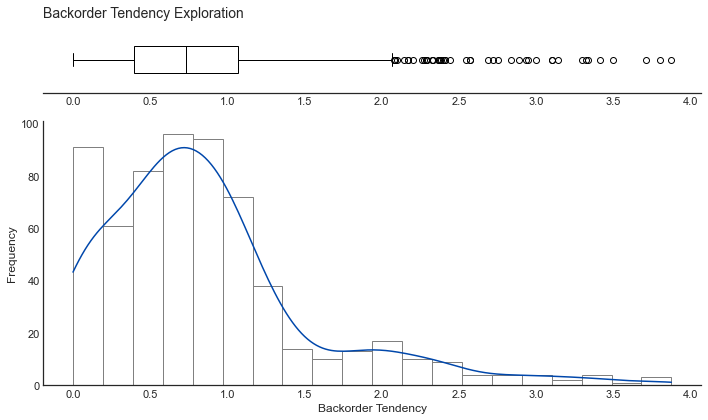

In [20]:
exp_plot(limiting_backorder_tendency,'max_quart_backorder_tendency',"Backorder Tendency Exploration",'Backorder Tendency')

In [21]:
# **** TRANSFORMATION ****
transformed_data = transform_column(limiting_backorder_tendency, 'max_quart_backorder_tendency')
columns_to_plot = [col for col in transformed_data.columns if "_backorder_tendency" in col]  
new_labels =   [
                "Original Backorder Tendency",
                "Quantile Transformer (Uniform)",
                "Standard Scaler",
                "Min-Max Scaler",
                "Robust Scaler",
                "Log Transformer",
                "Square Root Transformer",
                "Box-Cox Transformer",
                "Yeo-Johnson Transformer",
                "Max Absolute Scaler",
                "Arcsine Transformer",
                "Hyperbolic Tangent Transformer",
                "MAD Z-Score Transformer"
              ]

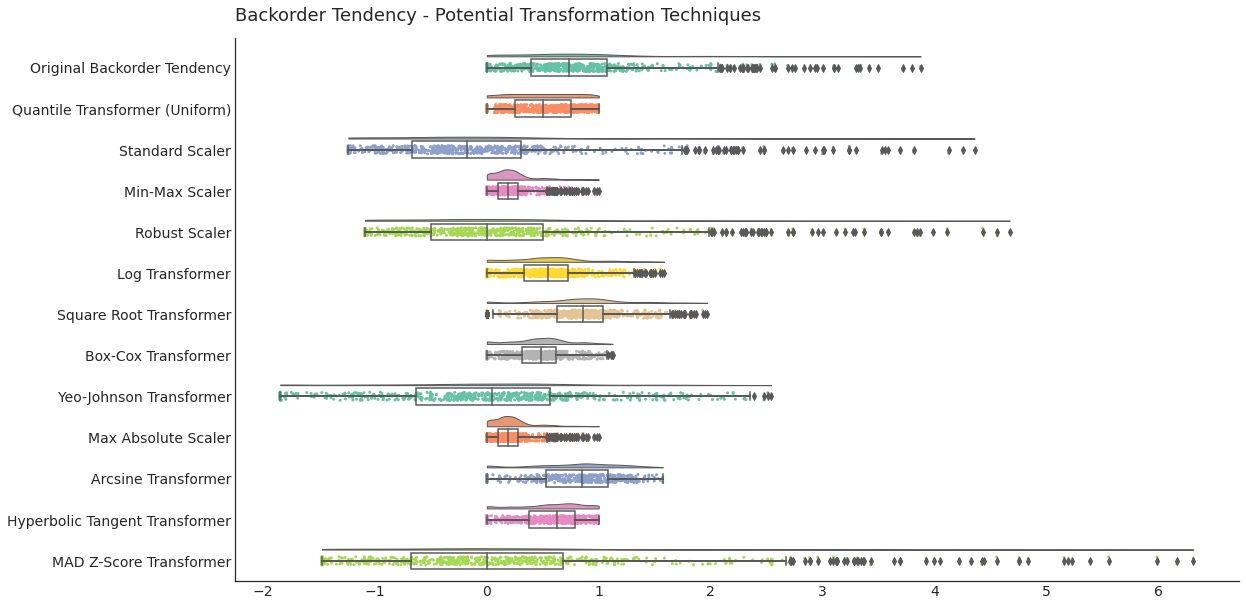

In [22]:
plot_transformed_data(transformed_data, columns_to_plot, "Backorder Tendency - Potential Transformation Techniques", new_labels=new_labels)


In [23]:
columns_to_plot= ["max_quart_backorder_tendency",'quantile_uniform_max_quart_backorder_tendency']
new_labels = ["Original Backorder Tendency" , "Transformed Backorder Tendency"]

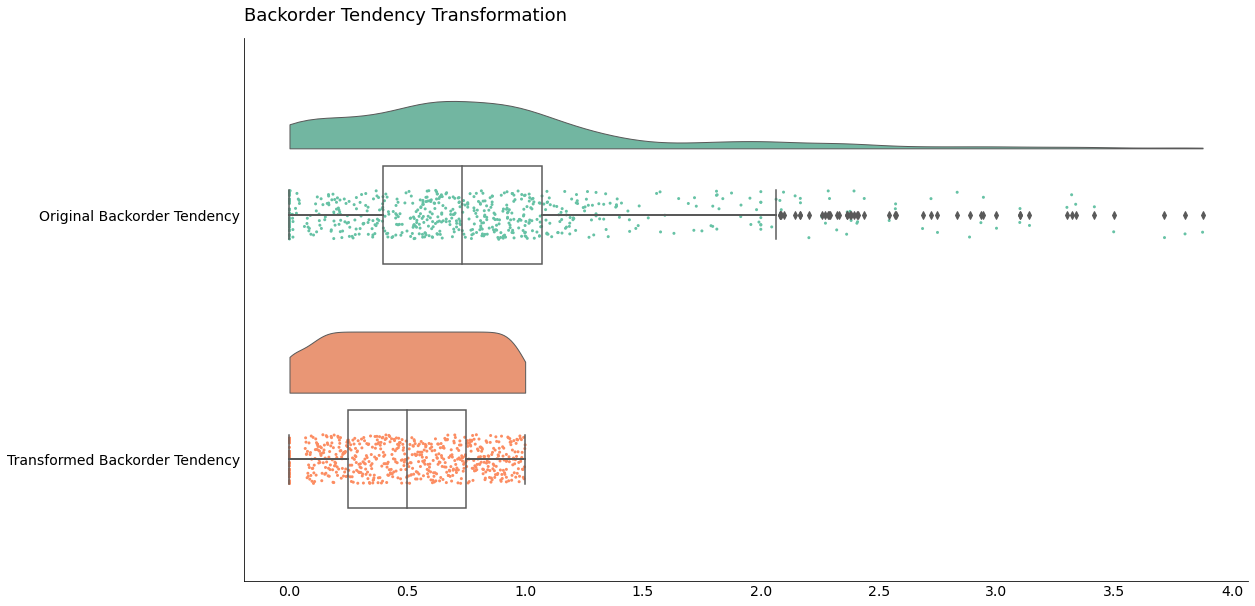

In [24]:
plot_transformed_data(transformed_data, columns_to_plot, "Backorder Tendency Transformation", new_labels=new_labels)

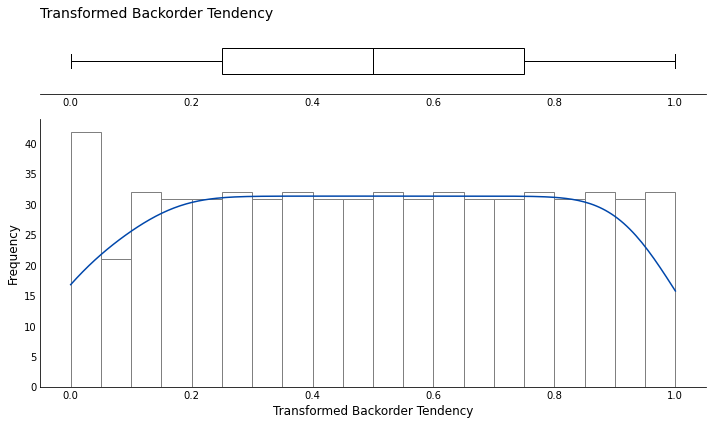

In [25]:
exp_plot(transformed_data,'quantile_uniform_max_quart_backorder_tendency',"Transformed Backorder Tendency",'Transformed Backorder Tendency')

# Capacity Sufficiency

In [26]:
transformed_data['capacity_insufficiency'] = 1/transformed_data.capacity_sufficiency

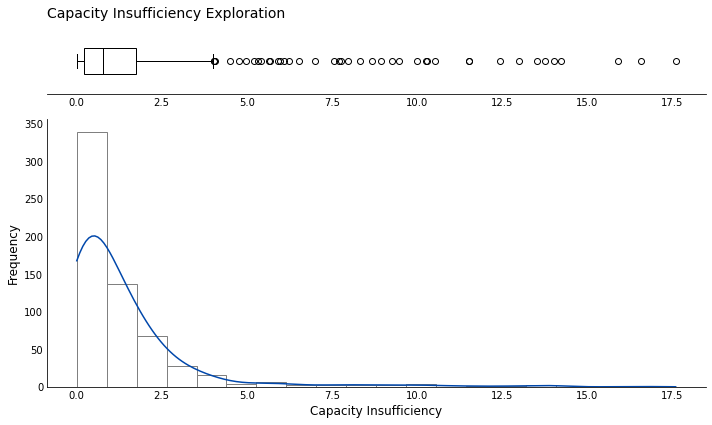

In [27]:
exp_plot(transformed_data,'capacity_insufficiency',"Capacity Insufficiency Exploration",'Capacity Insufficiency')

In [28]:
# **** TRANSFORMATION ****
transformed_data_v2 = transform_column(transformed_data, 'capacity_insufficiency')
columns_to_plot = [col for col in transformed_data_v2.columns if "capacity_insufficiency" in col]
transformed_data_v2.capacity_insufficiency.describe()

count   629.00
mean      1.47
std       2.35
min       0.00
25%       0.23
50%       0.78
75%       1.74
max      17.62
Name: capacity_insufficiency, dtype: float64

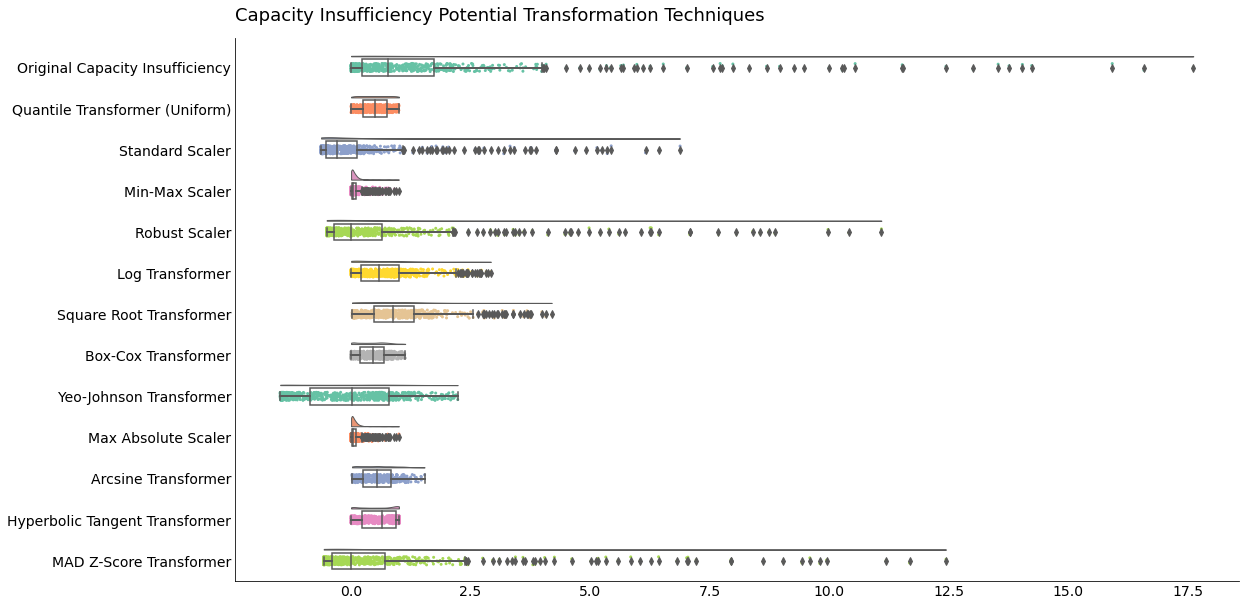

In [29]:
new_labels =   [
                        "Original Capacity Insufficiency",
                        "Quantile Transformer (Uniform)",
                        "Standard Scaler",
                        "Min-Max Scaler",
                        "Robust Scaler",
                        "Log Transformer",
                        "Square Root Transformer",
                        "Box-Cox Transformer",
                        "Yeo-Johnson Transformer",
                        "Max Absolute Scaler",
                        "Arcsine Transformer",
                        "Hyperbolic Tangent Transformer",
                        "MAD Z-Score Transformer"
              ]
              

plot_transformed_data(transformed_data_v2, columns_to_plot, "Capacity Insufficiency Potential Transformation Techniques", new_labels=new_labels)

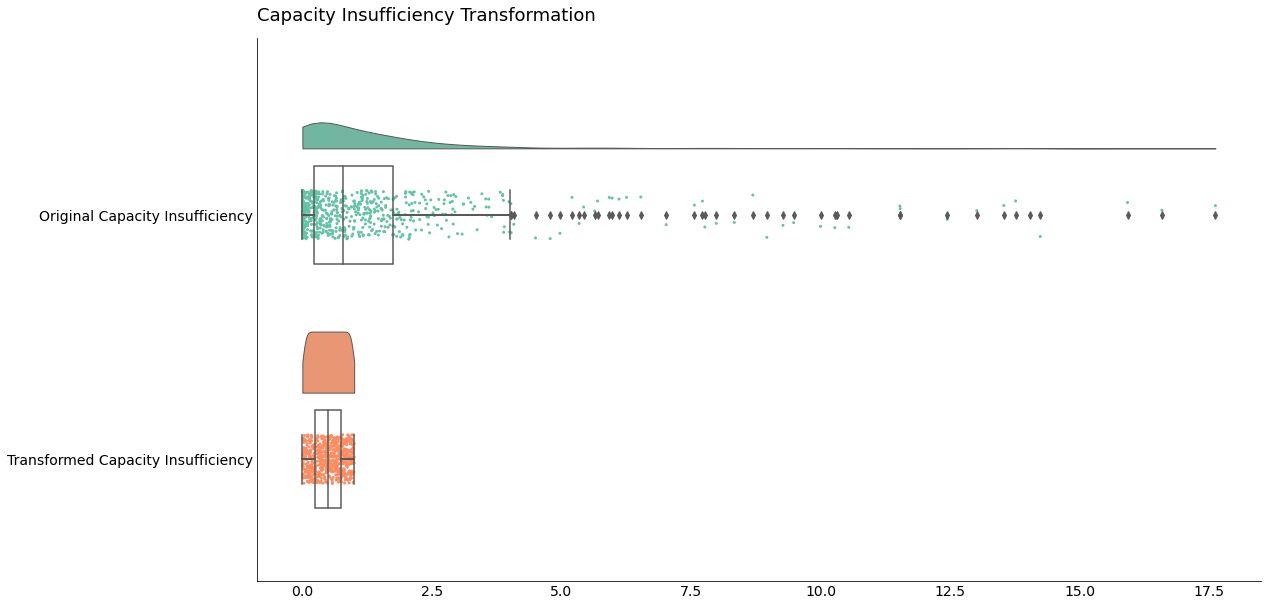

In [30]:
columns_to_plot= ["capacity_insufficiency",'quantile_uniform_capacity_insufficiency']
new_labels = ["Original Capacity Insufficiency" , "Transformed Capacity Insufficiency"]
plot_transformed_data(transformed_data_v2, columns_to_plot, "Capacity Insufficiency Transformation", new_labels=new_labels)

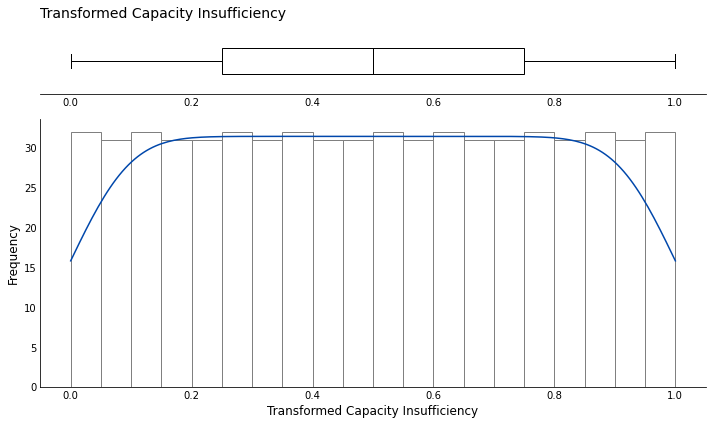

In [31]:
exp_plot(transformed_data_v2,'quantile_uniform_capacity_insufficiency',"Transformed Capacity Insufficiency",'Transformed Capacity Insufficiency')

# Annual Sales

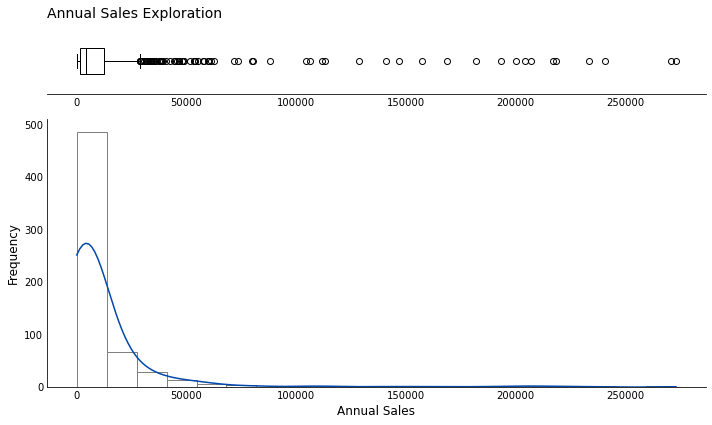

In [32]:
exp_plot(transformed_data_v2,'annual_sales',"Annual Sales Exploration",'Annual Sales')
# **** TRANSFORMATION ****
transformed_data_v3 = transform_column(transformed_data_v2, 'annual_sales')
columns_to_plot = [col for col in transformed_data_v3.columns if "_annual_sales" in col]

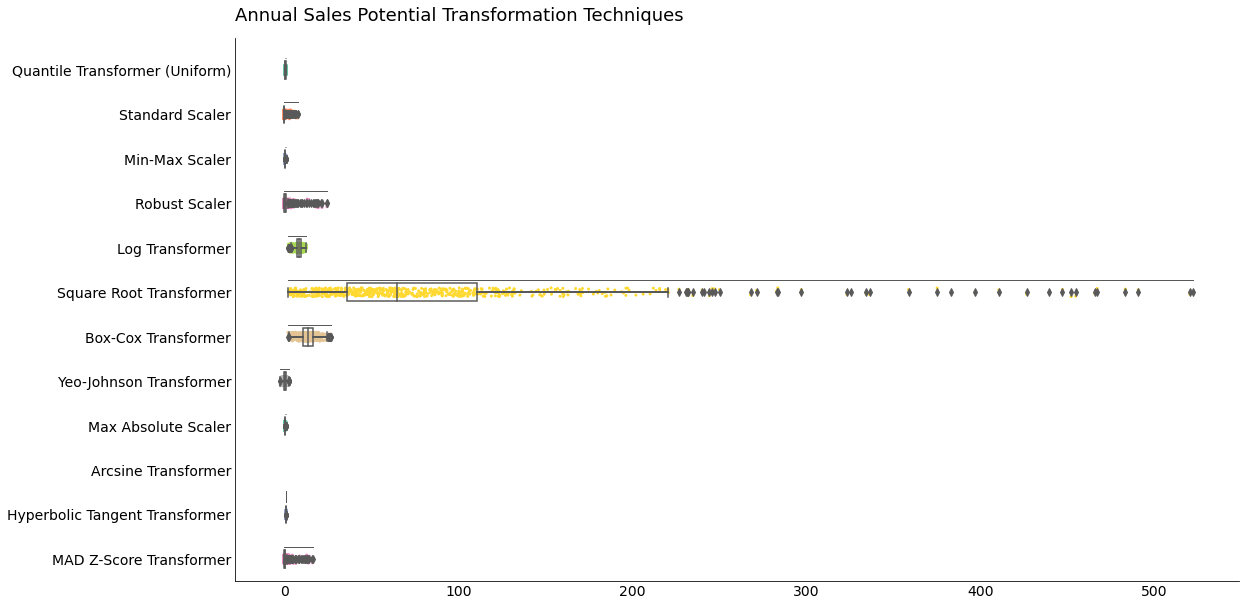

In [33]:
new_labels =   new_labels =   [ #"Original Annual Sales",
                        "Quantile Transformer (Uniform)",
                        "Standard Scaler",
                        "Min-Max Scaler",
                        "Robust Scaler",
                        "Log Transformer",
                        "Square Root Transformer",
                        "Box-Cox Transformer",
                        "Yeo-Johnson Transformer",
                        "Max Absolute Scaler",
                        "Arcsine Transformer",
                        "Hyperbolic Tangent Transformer",
                        "MAD Z-Score Transformer"
              ]
              

plot_transformed_data(transformed_data_v3, columns_to_plot, "Annual Sales Potential Transformation Techniques", new_labels=new_labels)

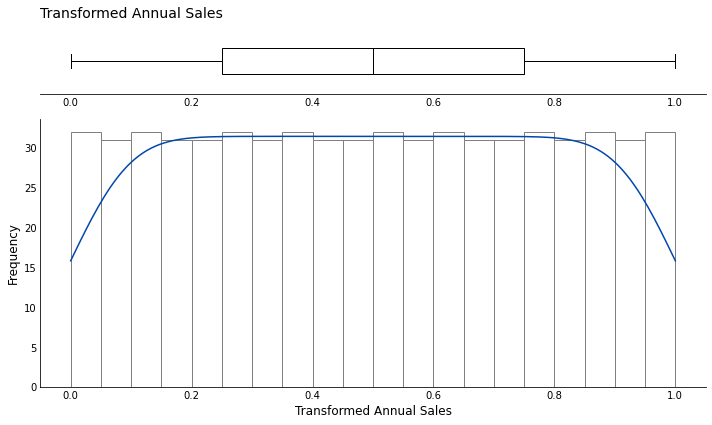

In [34]:
exp_plot(transformed_data_v3,'quantile_uniform_annual_sales',"Transformed Annual Sales",'Transformed Annual Sales')

# Seasonality

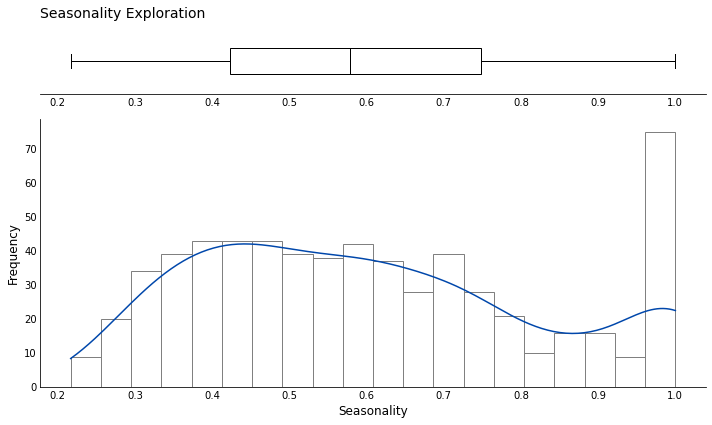

In [35]:
exp_plot(transformed_data_v3,'impulsive_ratio_order',"Seasonality Exploration",'Seasonality')
# **** TRANSFORMATION ****
transformed_data_v3['seasonality'] = transformed_data_v3['impulsive_ratio_order']
transformed_data_v4 = transform_column(transformed_data_v3, 'seasonality')
columns_to_plot = [col for col in transformed_data_v4.columns if "seasonality" in col]    

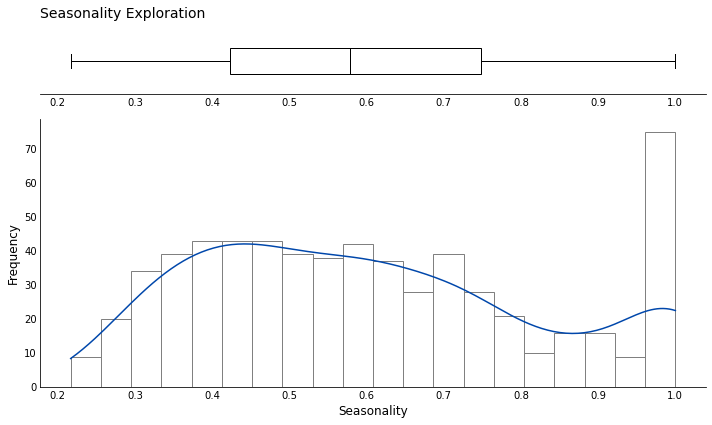

In [36]:
exp_plot(transformed_data_v4,'seasonality',"Seasonality Exploration",'Seasonality')

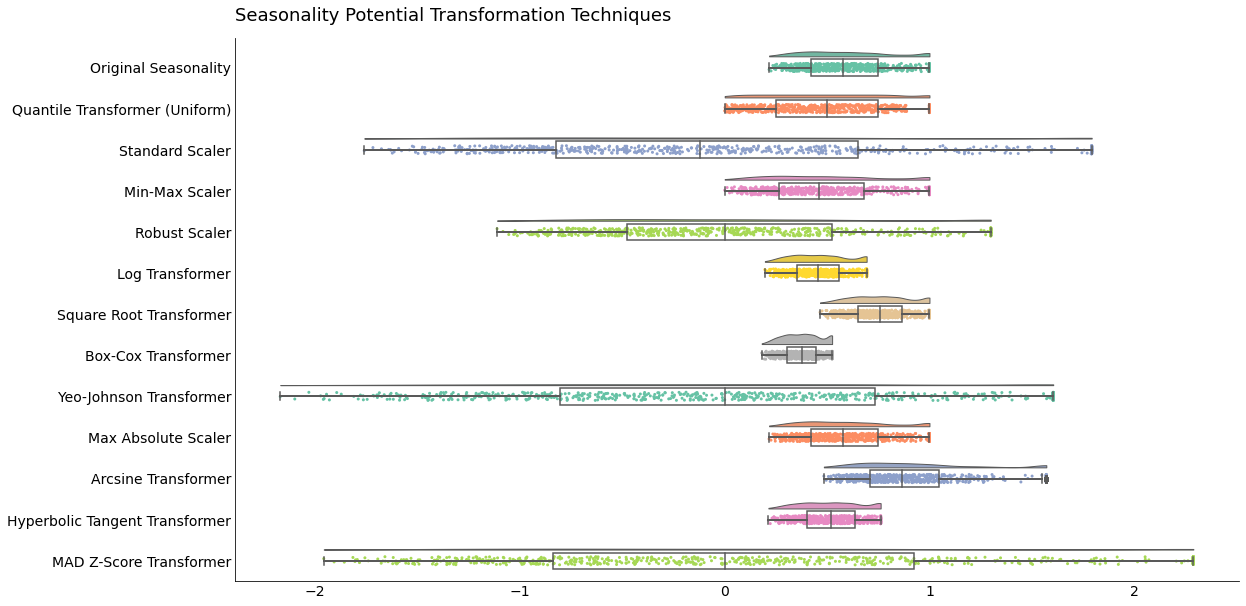

In [37]:
new_labels =   [        
                        "Original Seasonality",
                        "Quantile Transformer (Uniform)",
                        "Standard Scaler",
                        "Min-Max Scaler",
                        "Robust Scaler",
                        "Log Transformer",
                        "Square Root Transformer",
                        "Box-Cox Transformer",
                        "Yeo-Johnson Transformer",
                        "Max Absolute Scaler",
                        "Arcsine Transformer",
                        "Hyperbolic Tangent Transformer",
                        "MAD Z-Score Transformer"
              ]
              


plot_transformed_data(transformed_data_v4, columns_to_plot, "Seasonality Potential Transformation Techniques", new_labels=new_labels)


In [38]:
columns_to_plot= ['seasonality','quantile_uniform_seasonality']
new_labels = ["Original Seasonality" , "Transformed Seasonality"]

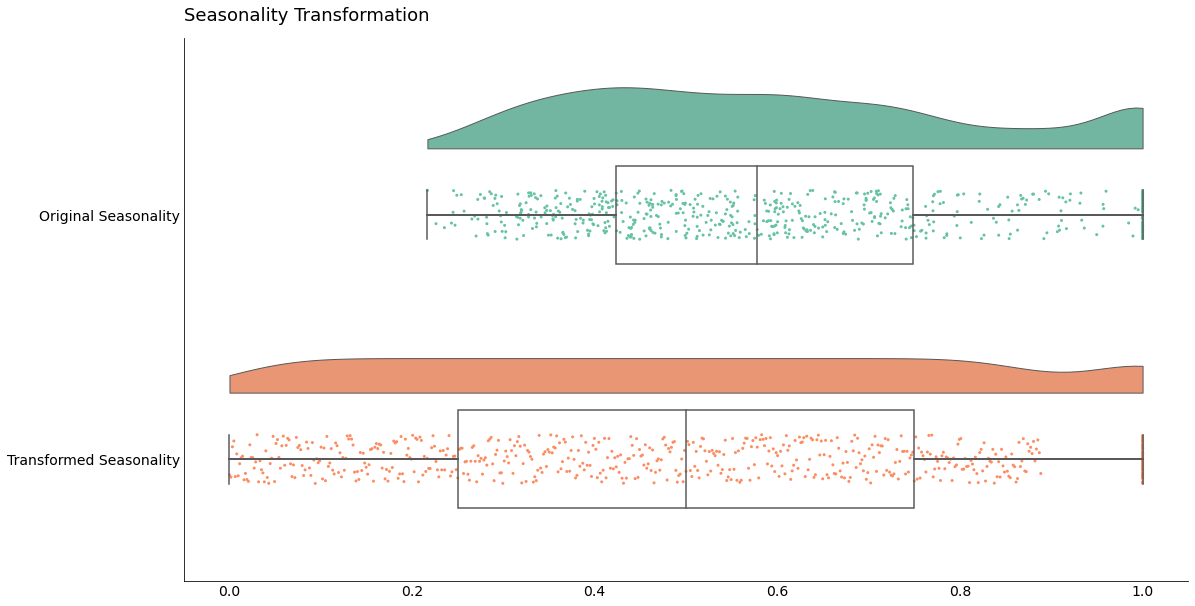

In [39]:
plot_transformed_data(transformed_data_v4, columns_to_plot, "Seasonality Transformation", new_labels=new_labels)

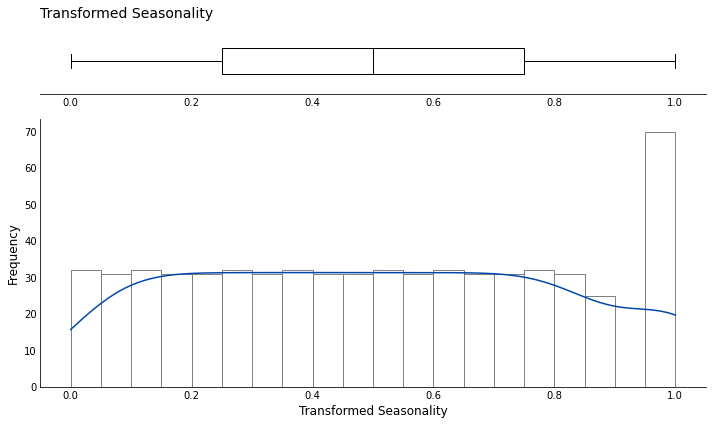

In [40]:
exp_plot(transformed_data_v4,'quantile_uniform_seasonality',"Transformed Seasonality",'Transformed Seasonality')

# AHP - Prebuild Score

In [41]:
df1 = transformed_data_v4.copy(deep=True)

In [42]:
#quantile_uniform_
df1['Annual_Sales'] = df1['quantile_uniform_annual_sales']
df1['Backorder_Tendency'] = df1['quantile_uniform_max_quart_backorder_tendency']
df1['Capacity_Insf.'] = df1['quantile_uniform_capacity_insufficiency']
df1['Seasonality'] = df1['quantile_uniform_seasonality']

In [43]:
df_p1_list = df1.copy(deep=True)

In [44]:
df_p1_list["AS"] =  0.161 * df_p1_list['Annual_Sales']
df_p1_list["BT"] =  0.294 * df_p1_list['Backorder_Tendency'] 
df_p1_list["CI"] =  0.485 * df_p1_list['Capacity_Insf.']
df_p1_list["S"]  =  0.06 * df_p1_list['Seasonality']

In [45]:
df_p1_list['Weighted_Sum'] = (df_p1_list["AS"]+
                                df_p1_list["BT"]+
                                df_p1_list["CI"]+
                                df_p1_list["S"] )

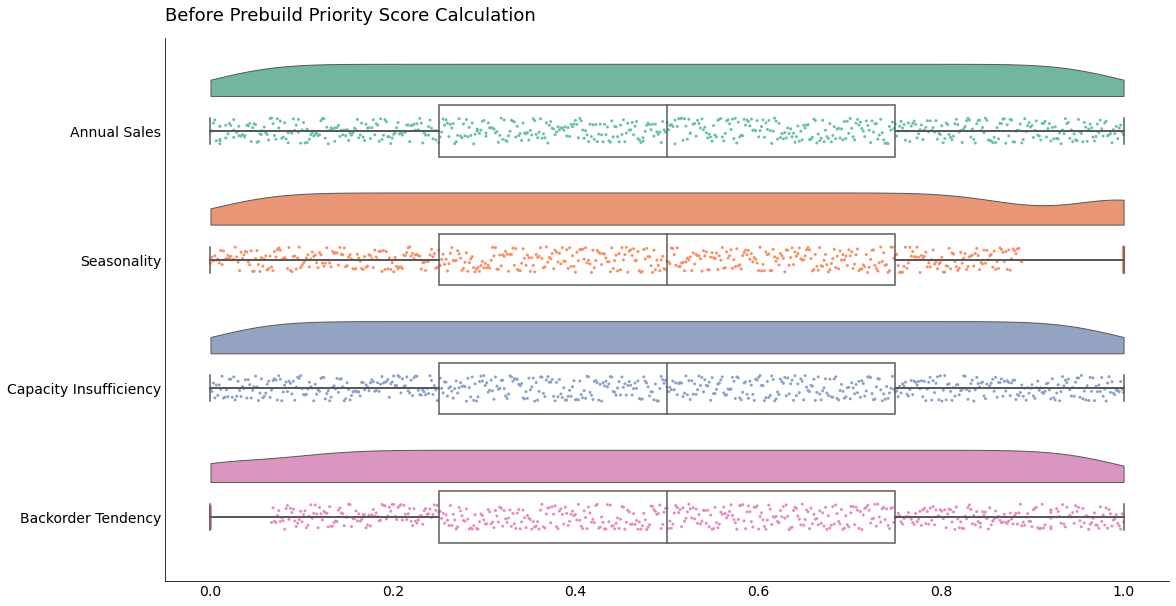

In [46]:
columns_to_plot= [
    
                   'Annual_Sales',
                    "Seasonality",
                       "Capacity_Insf.",
                   'Backorder_Tendency'
                  
                 ]
new_labels = ["Annual Sales" , "Seasonality", "Capacity Insufficiency","Backorder Tendency"]

plot_transformed_data(df_p1_list, columns_to_plot, "Before Prebuild Priority Score Calculation", new_labels=new_labels)

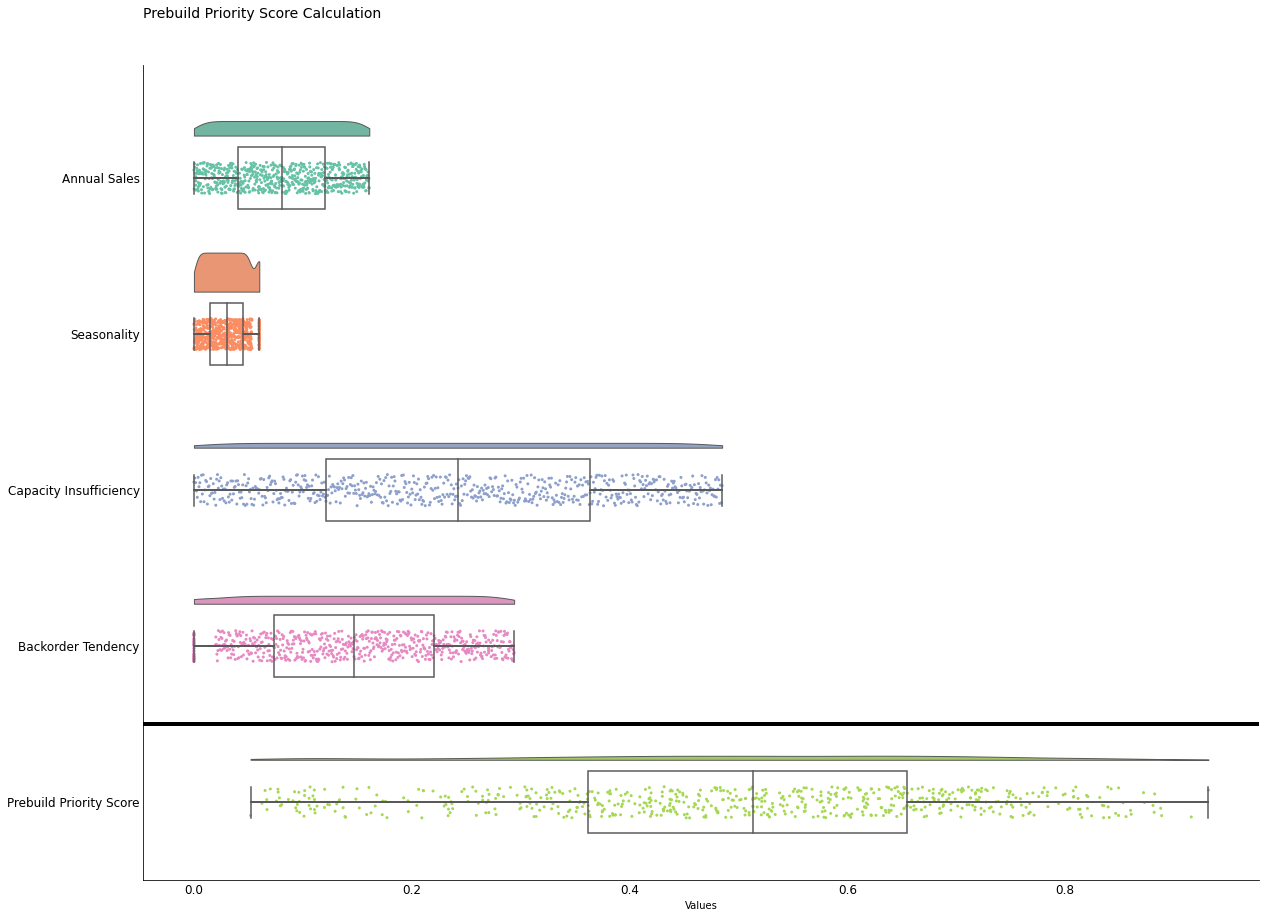

In [47]:
columns_to_plot= [ 'AS','S',"CI","BT",'Weighted_Sum']
new_labels = ["Annual Sales" , "Seasonality", "Capacity Insufficiency","Backorder Tendency",'Prebuild Priority Score']
plot_transformed_data_2(df_p1_list, columns_to_plot, "Prebuild Priority Score Calculation", new_labels=new_labels)

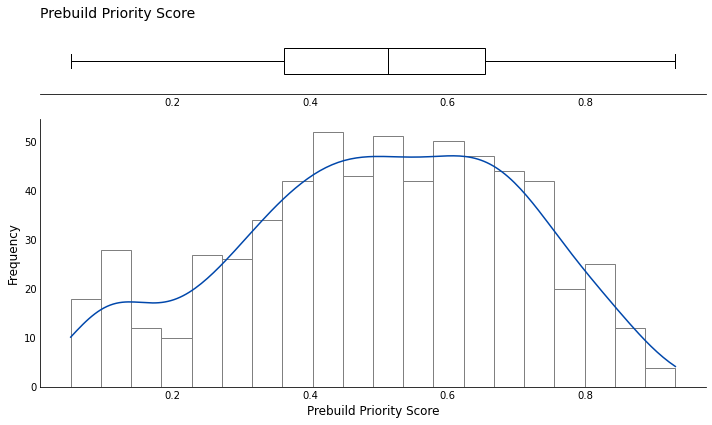

In [48]:
exp_plot(df_p1_list,'Weighted_Sum',"Prebuild Priority Score",'Prebuild Priority Score')

In [49]:
transformed_dimensions =(df_p1_list[ [
    
                   'Annual_Sales',
                    "Seasonality",
                       "Capacity_Insf.",
                   'Backorder_Tendency'
                  
                 ]])

original_dimensions = (df_p1_list[ [
    
                   'annual_sales',
                    'seasonality',
                    "capacity_insufficiency",
                    "max_quart_backorder_tendency"
                  
                  
                 ]])

In [50]:
rename_dict_transformed = {
    'Annual_Sales': 'Annual Sales',
    'Seasonality': 'Seasonality',
    'Capacity_Insf.': 'Capacity Ins.',
    'Backorder_Tendency': 'Backorder T.'
}

rename_dict_original = {
    'annual_sales': 'Annual Sales',
    'seasonality': 'Seasonality',
    'capacity_insufficiency': 'Capacity Ins.',
    'max_quart_backorder_tendency': 'Backorder T.'
}

transformed_dimensions = transformed_dimensions.rename(columns=rename_dict_transformed)
original_dimensions = original_dimensions.rename(columns=rename_dict_original)

In [51]:
transformed_dimensions.head(3)

,Annual Sales,Seasonality,Capacity Ins.,Backorder T.
0,0.92,0.75,0.79,0.21
1,0.94,0.50,0.89,0.11
2,0.95,0.71,0.89,0.19


In [52]:
original_dimensions.head(3)

,Annual Sales,Seasonality,Capacity Ins.,Backorder T.
0,36048,0.75,1.99,0.33
1,51417,0.58,2.86,0.12
2,53799,0.71,2.92,0.28


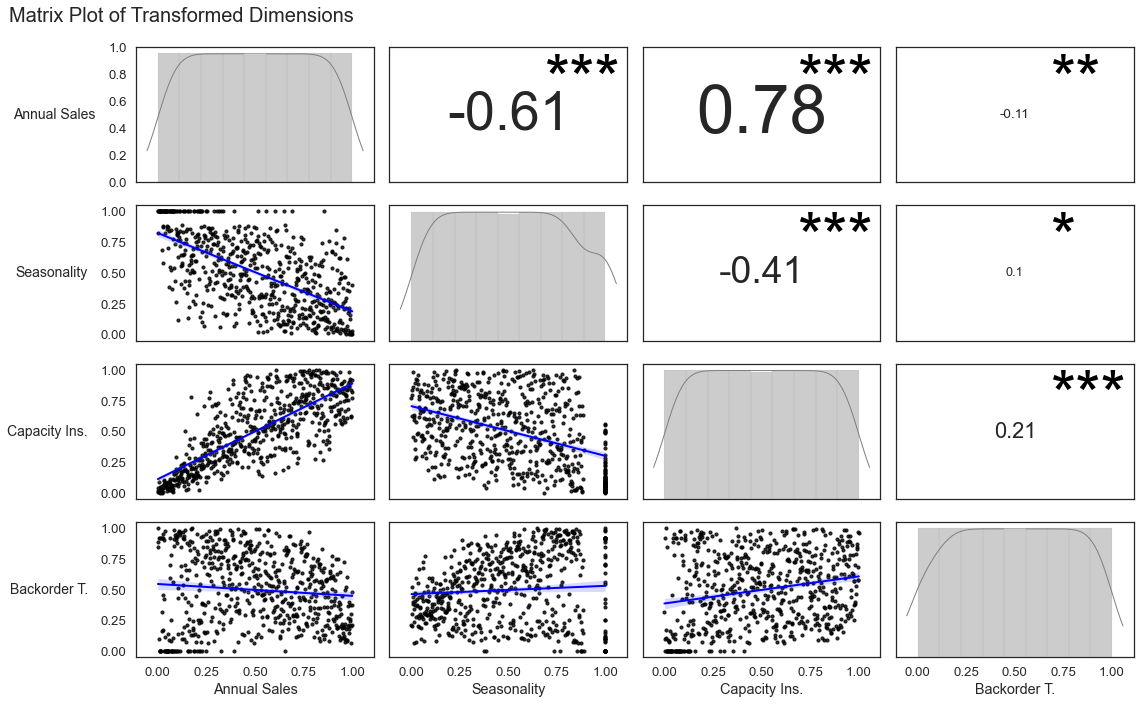

In [53]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'spearman')
    corr_text = round(corr_r, 2)
    ax = plt.gca()
    font_size = abs(corr_r) * 80 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)
    
def corrfunc(x, y, **kws):
    r, p = stats.spearmanr(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    ax = plt.gca()
    ax.annotate(p_stars, xy=(0.65, 0.6), xycoords=ax.transAxes,
                color='black', fontsize=65)

sns.set(style='white', font_scale=1.2)
g = sns.PairGrid(transformed_dimensions, aspect=1.6, diag_sharey=False, despine=False )


g.map_lower(sns.regplot, ci=90, 
            line_kws={'color': 'blue', 'lw': 2},
            scatter_kws={'color': 'black', 's': 10}) 

g.map_diag(sns.distplot, color='black', 
           kde_kws={'color': 'gray', 'cut': 0.7, 'lw': 1},
           hist_kws={'histtype': 'bar', 'lw': 0.15,
                     'edgecolor': 'grey', 'facecolor':'grey'})

g.fig.suptitle('Matrix Plot of Transformed Dimensions', size=20,x=0.16)

g.map_upper(corrdot)
g.map_upper(corrfunc)
g.fig.subplots_adjust(wspace=0, hspace=0)


labels = [ax.get_ylabel() for ax in g.axes[:, 0]]
for ax, label in zip(g.axes[:, 0], labels):
    ax.set_ylabel('')  # Clear the original y-label
    ax.annotate(label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=14, ha='right', va='center', rotation=0)


g.fig.tight_layout()


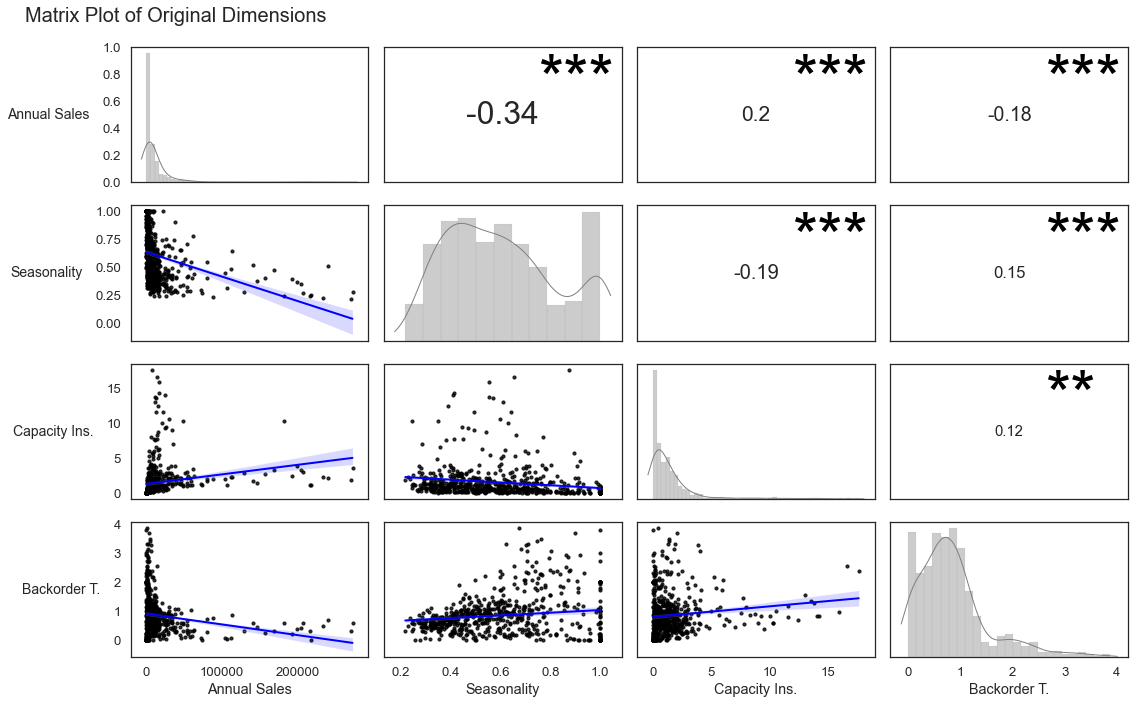

In [54]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = round(corr_r, 2)
    ax = plt.gca()
    font_size = abs(corr_r) * 80 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)
    
    
def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    ax = plt.gca()
    ax.annotate(p_stars, xy=(0.65, 0.6), xycoords=ax.transAxes,
                color='black', fontsize=65)


sns.set(style='white', font_scale=1.2)
g = sns.PairGrid(original_dimensions, aspect=1.6, diag_sharey=False, despine=False )


g.map_lower(sns.regplot, ci=90, 
            line_kws={'color': 'blue', 'lw': 2},
            scatter_kws={'color': 'black', 's': 10}) 

g.map_diag(sns.distplot, color='black', 
           kde_kws={'color': 'gray', 'cut': 0.7, 'lw': 1},
           hist_kws={'histtype': 'bar', 'lw': 0.15,
                     'edgecolor': 'grey', 'facecolor':'grey'})

g.fig.suptitle('Matrix Plot of Original Dimensions', size=20,x=0.16)

g.map_upper(corrdot)
g.map_upper(corrfunc)
g.fig.subplots_adjust(wspace=0, hspace=0)


labels = [ax.get_ylabel() for ax in g.axes[:, 0]]
for ax, label in zip(g.axes[:, 0], labels):
    ax.set_ylabel('')  # Clear the original y-label
    ax.annotate(label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=14, ha='right', va='center', rotation=0)


g.fig.tight_layout()


In [55]:
quantile_normal_scaler = QuantileTransformer(output_distribution='normal')
original_dimensions_n = original_dimensions.copy(deep=True)
for i in original_dimensions_n.columns:
    original_dimensions_n[f'{i}_N'] = quantile_normal_scaler.fit_transform(original_dimensions_n[i].values.reshape(-1, 1))

In [56]:
original_dimensions_n2 = original_dimensions_n[[i for i in original_dimensions_n.columns if '_N' in i]]

In [57]:
RS = {
    'Annual Sales_N': 'Annual Sales',
    'Seasonality_N': 'Seasonality',
    'Capacity Ins._N': 'Capacity Ins.',
    'Backorder T._N': 'Backorder T.'
}

original_dimensions_=original_dimensions_n2.rename(columns=RS)

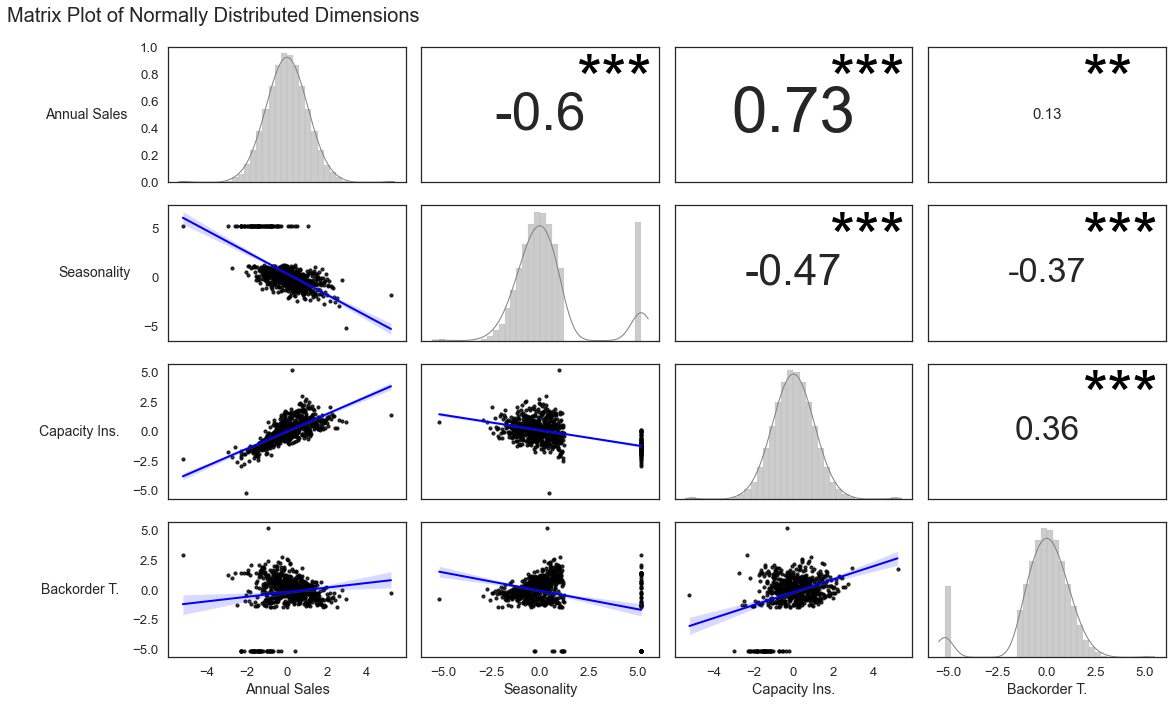

In [58]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = round(corr_r, 2)
    ax = plt.gca()
    font_size = abs(corr_r) * 80 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)
    
    
def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    ax = plt.gca()
    ax.annotate(p_stars, xy=(0.65, 0.6), xycoords=ax.transAxes,
                color='black', fontsize=65)


sns.set(style='white', font_scale=1.2)
g = sns.PairGrid(original_dimensions_, aspect=1.6, diag_sharey=False, despine=False )


g.map_lower(sns.regplot, ci=90, 
            line_kws={'color': 'blue', 'lw': 2},
            scatter_kws={'color': 'black', 's': 10}) 

g.map_diag(sns.distplot, color='black', 
           kde_kws={'color': 'gray', 'cut': 0.7, 'lw': 1},
           hist_kws={'histtype': 'bar', 'lw': 0.15,
                     'edgecolor': 'grey', 'facecolor':'grey'})

g.fig.suptitle('Matrix Plot of Normally Distributed Dimensions', size=20,x=0.16)

g.map_upper(corrdot)
g.map_upper(corrfunc)
g.fig.subplots_adjust(wspace=0, hspace=0)


labels = [ax.get_ylabel() for ax in g.axes[:, 0]]
for ax, label in zip(g.axes[:, 0], labels):
    ax.set_ylabel('')  # Clear the original y-label
    ax.annotate(label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=14, ha='right', va='center', rotation=0)


g.fig.tight_layout()

# Descriptive Stats

In [59]:
desc_stats = original_dimensions.describe().transpose()

# Compute skewness and kurtosis
desc_stats['skewness'] = original_dimensions.skew()
desc_stats['kurtosis'] = original_dimensions.kurt()
desc_stats.drop(columns='count', inplace=True)
desc_stats = desc_stats.rename(index=rename_dict_original)
desc_stats = desc_stats.reset_index(drop=False).rename(columns={"index": "Dimension"})
ordered_cols = ['Dimension', 'mean', 'std', 'min', '25%', '50%',  '75%', 'max', 'skewness', 'kurtosis']
desc_stats = desc_stats[ordered_cols]

desc_stats


,Dimension,mean,std,min,25%,50%,75%,max,skewness,kurtosis
0,Annual Sales,"14,668.53","34,192.26",5.00,"1,288.00","4,210.00","12,301.00","272,982.00",4.84,26.26
1,Seasonality,0.60,0.22,0.22,0.42,0.58,0.75,1.00,0.40,-0.89
2,Capacity Ins.,1.47,2.35,0.00,0.23,0.78,1.74,17.62,3.69,16.28
3,Backorder T.,0.86,0.69,0.00,0.40,0.73,1.07,3.87,1.50,2.83


In [60]:
desc_stats_transformed = transformed_dimensions.describe().transpose()
desc_stats_transformed['skewness'] = transformed_dimensions.skew()
desc_stats_transformed['kurtosis'] = transformed_dimensions.kurt()
desc_stats_transformed.drop(columns='count', inplace=True)

desc_stats_transformed = desc_stats_transformed.rename(index=rename_dict_transformed)
desc_stats_transformed = desc_stats_transformed.reset_index(drop=False).rename(columns={"index": "Dimension"})
ordered_cols = ['Dimension', 'mean', 'std', 'min', '25%', '50%',  '75%', 'max', 'skewness', 'kurtosis']
desc_stats_transformed = desc_stats_transformed[ordered_cols]

desc_stats_transformed


,Dimension,mean,std,min,25%,50%,75%,max,skewness,kurtosis
0,Annual Sales,0.50,0.29,0.00,0.25,0.50,0.75,1.00,-0.00,-1.20
1,Seasonality,0.51,0.30,0.00,0.25,0.50,0.75,1.00,0.09,-1.12
2,Capacity Ins.,0.50,0.29,0.00,0.25,0.50,0.75,1.00,0.00,-1.20
3,Backorder T.,0.50,0.29,0.00,0.25,0.50,0.75,1.00,-0.04,-1.16


# Comparison of Transformation Methods

In [61]:
df_p1_list['Weighted_Sum'].sort_values(ascending=False).head(3) #quantile transformer pbs. 

14    0.93
479   0.92
517   0.89
Name: Weighted_Sum, dtype: float64

In [62]:
[i for i in df_p1_list.columns if 'minmax_' in i]

['minmax_scaled_max_quart_backorder_tendency',
 'minmax_scaled_capacity_insufficiency',
 'minmax_scaled_annual_sales',
 'minmax_scaled_seasonality']

In [63]:
df_p1_list=df_p1_list.assign(Weighted_Sum_MinMax=( 0.161*df_p1_list['minmax_scaled_annual_sales']
                                       + 0.294*df_p1_list['minmax_scaled_max_quart_backorder_tendency']
                                       + 0.485*df_p1_list['minmax_scaled_capacity_insufficiency']
                                       + 0.06*df_p1_list['minmax_scaled_seasonality']))

In [64]:
# Define the quantiles for A, B, and C categories
A_quantile = 0.8  # Top 20%
B_quantile = 0.5  # Next 30%

# Assign categories for Weighted_Sum
df_p1_list['Category_Weighted_Sum'] = pd.cut(df_p1_list['Weighted_Sum'], 
                                             bins=[0, 
                                                   df_p1_list['Weighted_Sum'].quantile(B_quantile), 
                                                   df_p1_list['Weighted_Sum'].quantile(A_quantile), 
                                                   df_p1_list['Weighted_Sum'].max()], 
                                             labels=['C', 'B', 'A'], 
                                             include_lowest=True)

# Assign categories for Weighted_Sum_MinMax
df_p1_list['Category_Weighted_Sum_MinMax'] = pd.cut(df_p1_list['Weighted_Sum_MinMax'], 
                                                    bins=[0, 
                                                          df_p1_list['Weighted_Sum_MinMax'].quantile(B_quantile), 
                                                          df_p1_list['Weighted_Sum_MinMax'].quantile(A_quantile), 
                                                          df_p1_list['Weighted_Sum_MinMax'].max()], 
                                                    labels=['C', 'B', 'A'], 
                                                    include_lowest=True)



In [65]:
# Using the previously categorized df_p1_list

# Count for each category in Weighted_Sum
category_counts_weighted_sum = df_p1_list['Category_Weighted_Sum'].value_counts()

# Count for each category in Weighted_Sum_MinMax
category_counts_weighted_sum_minmax = df_p1_list['Category_Weighted_Sum_MinMax'].value_counts()

# Print out counts
print("Counts for Weighted_Sum:")
print(category_counts_weighted_sum)
print("\nCounts for Weighted_Sum_MinMax:")
print(category_counts_weighted_sum_minmax)


Counts for Weighted_Sum:
C    315
B    188
A    126
Name: Category_Weighted_Sum, dtype: int64

Counts for Weighted_Sum_MinMax:
C    315
B    188
A    126
Name: Category_Weighted_Sum_MinMax, dtype: int64


In [66]:
# Identifying products that are 'A' in Weighted_Sum but not in Weighted_Sum_MinMax
diff_products_A = df_p1_list[(df_p1_list['Category_Weighted_Sum'] == 'A') & (df_p1_list['Category_Weighted_Sum_MinMax'] != 'A')]
diff_products_B = df_p1_list[(df_p1_list['Category_Weighted_Sum'] == 'B') & (df_p1_list['Category_Weighted_Sum_MinMax'] != 'B')]
diff_products_C = df_p1_list[(df_p1_list['Category_Weighted_Sum'] == 'C') & (df_p1_list['Category_Weighted_Sum_MinMax'] != 'C')]

diff_products_A.shape, diff_products_B.shape , diff_products_C.shape

((47, 94), (81, 94), (57, 94))

In [67]:
# Renaming categories to specify the transformation method
df_p1_list['Category_Weighted_Sum_1'] = df_p1_list['Category_Weighted_Sum'].astype(str) + '_Quantile'
df_p1_list['Category_Weighted_Sum_MinMax_1'] = df_p1_list['Category_Weighted_Sum_MinMax'].astype(str) + '_MinMax'

cross_table = pd.crosstab(df_p1_list['Category_Weighted_Sum_1'], df_p1_list['Category_Weighted_Sum_MinMax_1'], margins=True, margins_name="Total")
display(cross_table)


Category_Weighted_Sum_MinMax_1,A_MinMax,B_MinMax,C_MinMax,Total
Category_Weighted_Sum_1,,,,
A_Quantile,79,47,0,126
B_Quantile,24,107,57,188
C_Quantile,23,34,258,315
Total,126,188,315,629


In [68]:
# Compute the cross-tabulation
cross_table = pd.crosstab(df_p1_list['Category_Weighted_Sum_1'], df_p1_list['Category_Weighted_Sum_MinMax_1'])

# Convert to row percentages
cross_table_percentage = cross_table.div(cross_table.sum(axis=1), axis=0) * 100

display(cross_table_percentage)


Category_Weighted_Sum_MinMax_1,A_MinMax,B_MinMax,C_MinMax
Category_Weighted_Sum_1,,,
A_Quantile,62.70,37.30,0.00
B_Quantile,12.77,56.91,30.32
C_Quantile,7.30,10.79,81.90


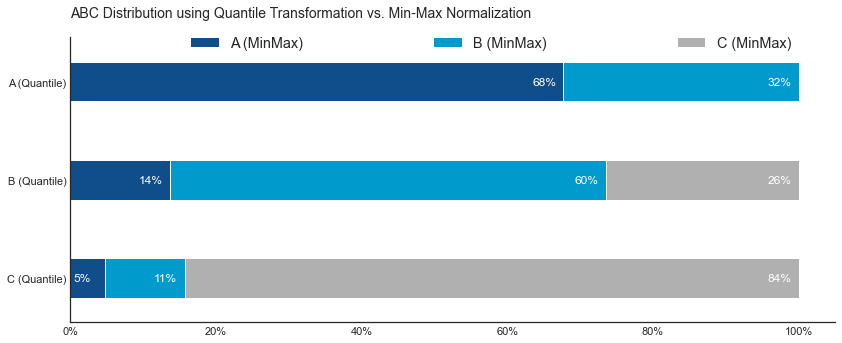

In [69]:
data = {
    'A_MinMax': [86, 26, 15],
    'B_MinMax': [41, 113, 35],
    'C_MinMax': [0, 50, 267]
}
index = ['A (Quantile)', 'B (Quantile)', 'C (Quantile)']
df = pd.DataFrame(data, index=index)

df = df.loc[ ['A (Quantile)', 'B (Quantile)', 'C (Quantile)']]
df = df.iloc[::-1]
normalized_df = (df.div(df.sum(axis=1), axis=0) * 100).round(2)

palette = ["#104E8B", "#009ACD", "#B0B0B0"]

ax = normalized_df.plot(kind='barh', stacked=True, color=palette, figsize=(12, 5), fontsize=11, width=0.4)
ax.set_title("ABC Distribution using Quantile Transformation vs. Min-Max Normalization", fontsize=14, loc='left', y=1.05)

ax.set_xticks(np.arange(0, 101, 20))
ax.set_xticklabels(['{}%'.format(int(val)) for val in ax.get_xticks()])

ax.set_xlabel('')
for rect in ax.patches:
    width = rect.get_width()
    if width > 0:
        x = rect.get_x() + width - 4.3  # adjust the position if needed
        y = rect.get_y() + rect.get_height() / 2
        ax.text(x, y, "{:.0f}%".format(width), ha='left', va='center', color='white', fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='both', length=0)

handles, _ = ax.get_legend_handles_labels()
new_labels = ['A (MinMax)', 'B (MinMax)', 'C (MinMax)']
ax.legend(handles, new_labels, loc='upper center', bbox_to_anchor=(0.55, 1.05), ncol=3, fancybox=False, framealpha=0, columnspacing=9, fontsize='medium')
plt.tight_layout()
plt.show()




In [70]:
orig_feature_values = ['max_quart_backorder_tendency','capacity_insufficiency',
                      'annual_sales','seasonality']
diff_products_A[ [col for col in diff_products_A.columns if "_uniform" in col]+ [col for col in diff_products_A.columns if "minmax_" in col] + orig_feature_values ].head(2).columns 
[col for col in diff_products_A.columns if "_uniform" in col]

['quantile_uniform_max_quart_backorder_tendency',
 'quantile_uniform_capacity_insufficiency',
 'quantile_uniform_annual_sales',
 'quantile_uniform_seasonality']

In [71]:
#diff_products_A; 'Category_Weighted_Sum_MinMax=="C"'-> Will be changed,  TO CREATE TABLES
C = diff_products_A.query('Category_Weighted_Sum_MinMax=="B"')[['quantile_uniform_max_quart_backorder_tendency',
       'quantile_uniform_capacity_insufficiency',
       'quantile_uniform_annual_sales', 'quantile_uniform_seasonality',
       'minmax_scaled_max_quart_backorder_tendency',
       'minmax_scaled_capacity_insufficiency', 'minmax_scaled_annual_sales',
       'minmax_scaled_seasonality', 'max_quart_backorder_tendency',
       'capacity_insufficiency', 'annual_sales', 'seasonality',  'Weighted_Sum_MinMax',
                                                               'Weighted_Sum',
                                                                'Category_Weighted_Sum_MinMax',
                                                           'Category_Weighted_Sum'
]].sort_values(by='annual_sales',ascending=False).head(11).iloc[1:]
desired_order = [
    ('Backorder Tendency', 'Original Value', 'max_quart_backorder_tendency'),
    ('Backorder Tendency', 'Quantile Transform', 'quantile_uniform_max_quart_backorder_tendency'),
    ('Backorder Tendency', 'Min-Max Normalization', 'minmax_scaled_max_quart_backorder_tendency'),
    ('Capacity Insufficiency', 'Original Value', 'capacity_insufficiency'),
    ('Capacity Insufficiency', 'Quantile Transform', 'quantile_uniform_capacity_insufficiency'),
    ('Capacity Insufficiency', 'Min-Max Normalization', 'minmax_scaled_capacity_insufficiency'),
    ('Annual Sales', 'Original Value', 'annual_sales'),
    ('Annual Sales', 'Quantile Transform', 'quantile_uniform_annual_sales'),
    ('Annual Sales', 'Min-Max Normalization', 'minmax_scaled_annual_sales'),
    ('Seasonality', 'Original Value', 'seasonality'),
    ('Seasonality', 'Quantile Transform', 'quantile_uniform_seasonality'),
    ('Seasonality', 'Min-Max Normalization', 'minmax_scaled_seasonality'),
        ('Category', 'MinMax_Score', 'Weighted_Sum_MinMax'),
    ('Category', 'Quantile_Score', 'Weighted_Sum'),
    ('Category', 'MinMax', 'Category_Weighted_Sum_MinMax'),
    ('Category', 'Quantile', 'Category_Weighted_Sum')

]

# Extract the columns in the desired order from the DataFrame
C = C[[col[2] for col in desired_order]]

# Rename the columns to multi-level columns
C.columns = pd.MultiIndex.from_tuples([(col[0], col[1]) for col in desired_order])



In [72]:
df_p1_list.iloc[:,12:].head()

,OT_total_sales,annual_order,annual_production,avg_inventory,inv_turnover,max_backorder,avg_backorder,capacity_sufficiency,max_quart_backorder_tendency,gm,...,AS,BT,CI,S,Weighted_Sum,Weighted_Sum_MinMax,Category_Weighted_Sum,Category_Weighted_Sum_MinMax,Category_Weighted_Sum_1,Category_Weighted_Sum_MinMax_1
0,0,35979,36930,468.67,76.92,112798,"51,900.17",0.50,0.33,32.00,...,0.15,0.06,0.39,0.04,0.64,0.14,B,B,B_Quantile,B_MinMax
1,0,60317,54608,"1,024.62",50.18,112364,"55,739.58",0.35,0.12,25.00,...,0.15,0.03,0.43,0.03,0.64,0.15,B,B,B_Quantile,B_MinMax
2,0,60691,56127,959.17,56.09,109324,"51,507.50",0.34,0.28,22.00,...,0.15,0.06,0.43,0.04,0.68,0.17,B,B,B_Quantile,B_MinMax
3,0,31521,30469,576.00,50.68,96274,"46,955.42",0.28,0.21,23.00,...,0.14,0.05,0.44,0.04,0.68,0.17,B,B,B_Quantile,B_MinMax
4,0,56142,62509,692.17,88.29,139318,"62,174.58",0.30,0.30,30.00,...,0.15,0.06,0.44,0.05,0.70,0.19,A,A,A_Quantile,A_MinMax


## Products' Dimensions by ABC

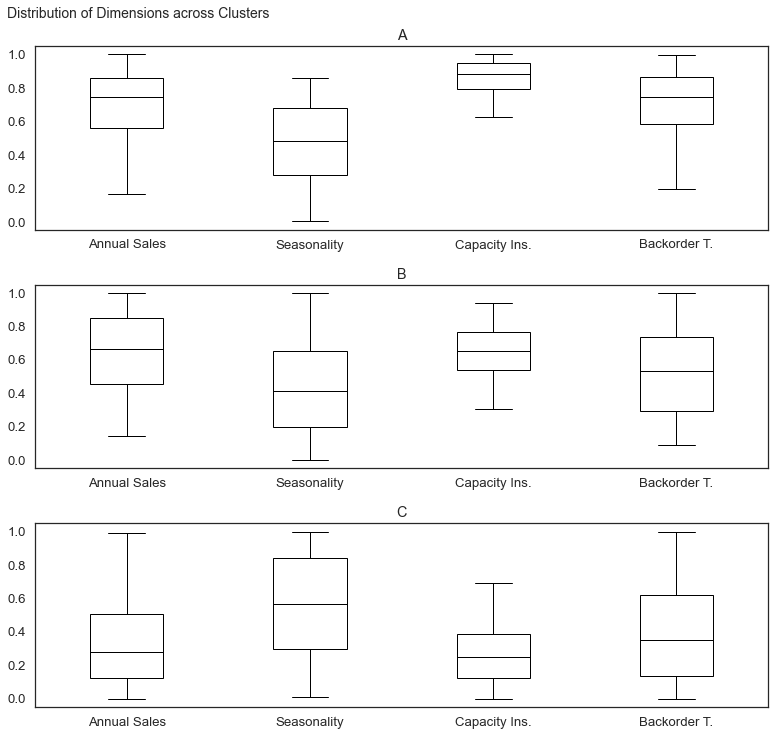

In [73]:
assigned_clusters = df_p1_list['Category_Weighted_Sum']
features= ['Annual Sales', 'Seasonality', 'Capacity Ins.', 'Backorder T.']
create_uniform_cluster_boxplots(transformed_dimensions, assigned_clusters, features)

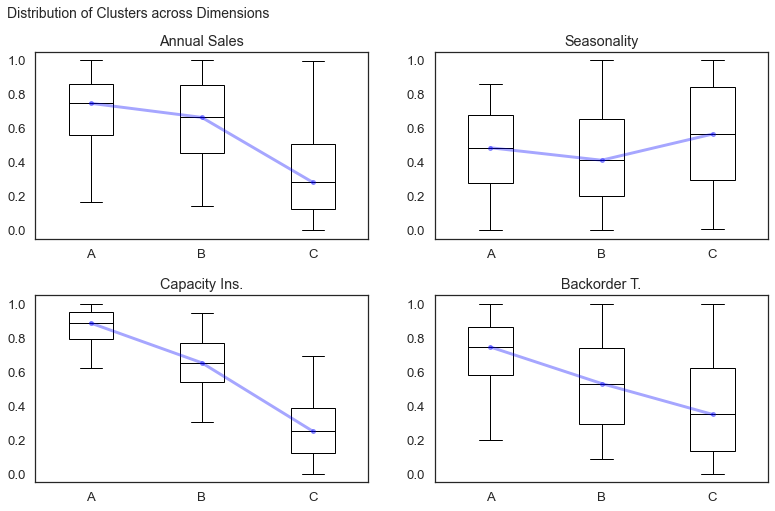

In [74]:
create_cluster_boxplots(transformed_dimensions, df_p1_list['Category_Weighted_Sum'])

In [76]:
minmax_  = df_p1_list [['minmax_scaled_max_quart_backorder_tendency',
       'minmax_scaled_capacity_insufficiency', 'minmax_scaled_annual_sales',
       'minmax_scaled_seasonality']].copy()

In [77]:
minmax_ = minmax_.rename({'minmax_scaled_max_quart_backorder_tendency':'Backorder T.',
       'minmax_scaled_capacity_insufficiency': 'Capacity Ins.', 'minmax_scaled_annual_sales':'Annual Sales',
       'minmax_scaled_seasonality':'Seasonality'},axis=1)

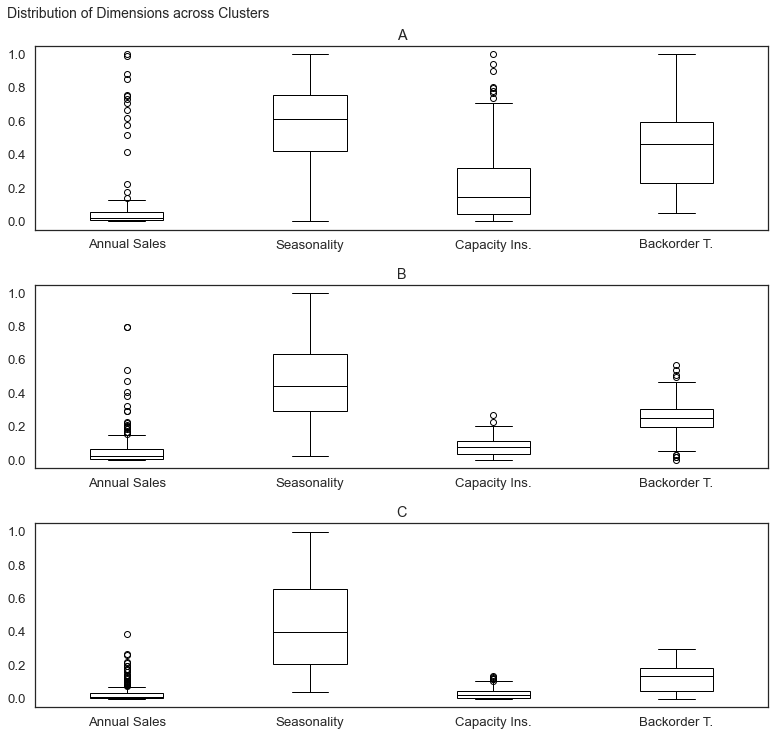

In [78]:
assigned_clusters = df_p1_list['Category_Weighted_Sum_MinMax']
features= ['Annual Sales', 'Seasonality', 'Capacity Ins.', 'Backorder T.']
create_uniform_cluster_boxplots(minmax_, assigned_clusters, features)
#some kind of analyzing for centroids.

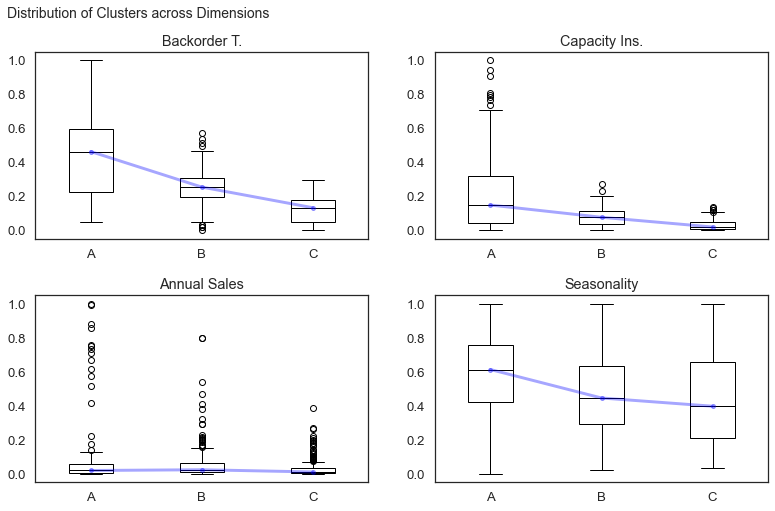

In [79]:
create_cluster_boxplots(minmax_, df_p1_list['Category_Weighted_Sum_MinMax'])

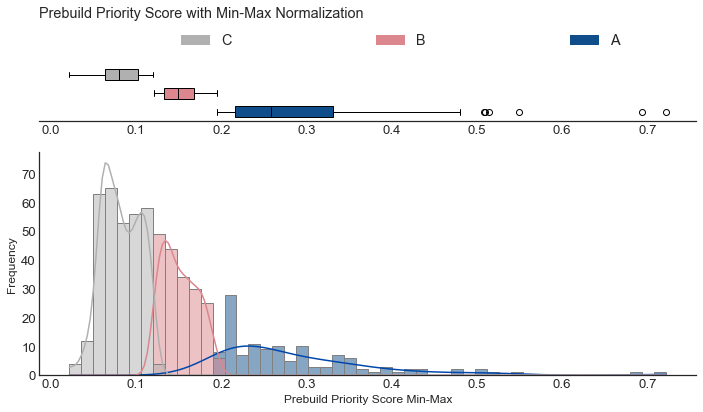

In [80]:
exp_plot_3(df_p1_list,'Weighted_Sum_MinMax',"Prebuild Priority Score with Min-Max Normalization",'Prebuild Priority Score Min-Max')

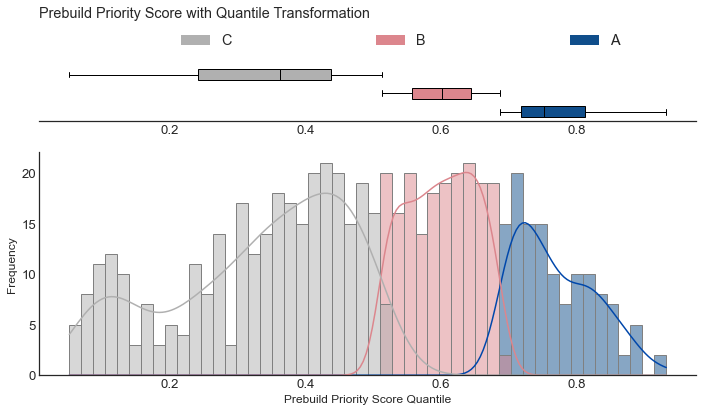

In [81]:
exp_plot_4(df_p1_list,'Weighted_Sum',"Prebuild Priority Score with Quantile Transformation",'Prebuild Priority Score Quantile')